<a href="https://colab.research.google.com/github/Lipinor/deep_learning_cbpf/blob/master/Credit_Card_Fraud_Detection_Filipe_Melo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Credit Card Fraud Detection

In this notebook we are going to propose a solution to the Credit Card Fraud Dataset from Kaggle (https://www.kaggle.com/mlg-ulb/creditcardfraud). It consists of credit card transactions made in September 2013 by european customers, classified between fraud and non-fraud. The goal is to train a model that is able to identify fraudulent transactions. The principal feature of this dataset is the imbalance between the classes: less than 0.2% of the dataset consists of fradulent transactions. This brings some challenges to the training that we are going to exploit in this notebook. 

#Setup

Let's begin by importing the necessary libraries:

In [154]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Dataset

Here we download the dataset from Kaggle:

In [155]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This dataset is composed of credit card transactions made in September 2013 by european customers. The feature 'Time' is the time elapsed between a given transaction and the first one in the dataset (in seconds), 'Amount' is the amount of the transaction, and features 'V1' to 'V28' are numerical input variables whose background is unknown due to confidentiality issues. The classes are 0 (non-fraud, or negative) and 1 (fraud, or positive).

In [156]:
raw_df[['Time','Amount','V1','V2','V3','V26','V27','V28','Class']]

,Time,Amount,V1,V2,V3,V26,V27,V28,Class
0,0.0,149.62,-1.359807,-0.072781,2.536347,-0.189115,0.133558,-0.021053,0
1,0.0,2.69,1.191857,0.266151,0.166480,0.125895,-0.008983,0.014724,0
2,1.0,378.66,-1.358354,-1.340163,1.773209,-0.139097,-0.055353,-0.059752,0
3,1.0,123.50,-0.966272,-0.185226,1.792993,-0.221929,0.062723,0.061458,0
4,2.0,69.99,-1.158233,0.877737,1.548718,0.502292,0.219422,0.215153,0
...,...,...,...,...,...,...,...,...,...
284802,172786.0,0.77,-11.881118,10.071785,-9.834783,0.250034,0.943651,0.823731,0
284803,172787.0,24.79,-0.732789,-0.055080,2.035030,-0.395255,0.068472,-0.053527,0
284804,172788.0,67.88,1.919565,-0.301254,-3.249640,-0.087371,0.004455,-0.026561,0
284805,172788.0,10.00,-0.240440,0.530483,0.702510,0.546668,0.108821,0.104533,0


#Exploratory Data Analysis (EDA)

We begin by analyzing how the classes in the dataset are balanced using the np.bincount function from NumPy. 

In [157]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total, neg, 100 * neg / total, pos, 100 * pos / total))

Examples:
  Total: 284807
  Negative: 284315 (99.83% of total)
  Positive: 492 (0.17% of total)



This dataset is heavily imbalanced: only 0.17% of the transactions are classified as frauds. 

First, let's  see how 'Time' and 'Amount', the only features that we know the meaning, are distributed.

In [158]:
print ("Time - Fraud")
print (raw_df.Time[raw_df.Class == 1].describe())
print ()
print ("Time - Normal")
print (raw_df.Time[raw_df.Class == 0].describe())

Time - Fraud
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Time - Normal
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


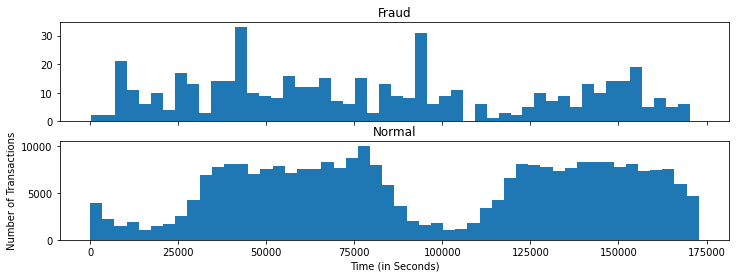

In [159]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 50

ax1.hist(raw_df.Time[raw_df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(raw_df.Time[raw_df.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

It's not easy to take any conclusion from these distributions, but one can notice that fraudulent transactions contain more peaks in certain time instants, while the legitimate transactions are generally concentrated in certain time periods (maybe we can guess that these periods refer to the commercial time, when most of the customers are shopping). This could make it easier to detect fraud when it takes place outside of these time limits.

In [160]:
print ("Amount - Fraud")
print (raw_df.Amount[raw_df.Class == 1].describe())
print ()
print ("Amount - Normal")
print (raw_df.Amount[raw_df.Class == 0].describe())

Amount - Fraud
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

Amount - Normal
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


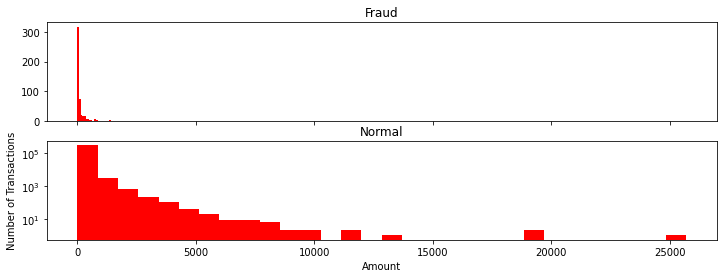

In [161]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(raw_df.Amount[raw_df.Class == 1], color = 'r', bins = bins)
ax1.set_title('Fraud')

ax2.hist(raw_df.Amount[raw_df.Class == 0], color = 'r', bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

It is clearly that fraudulent transactions are in general of small amounts, probably because this kind of transaction is less likely to draw the customer attention. Therefore, this is a very important feature for the model to learn. 

##Data Cleaning

We need to clean the data. First, we are going to check if the dataset contains any null values.

In [162]:
raw_df.isnull().sum() 

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

This is not the case, so we will not need to worry about filling empty features.

#Splitting and normalizing the data

We need to split the data between train and test sets. 

* The train data is used to fit the model. 

* The test data is used at the end of the training to see how the model generalizes to new data.

In [163]:
# Here we use a utility from sklearn to help us split and shuffle the dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.2)

train_df_features = train_df.copy()
test_df_features = test_df.copy()

# Convert the DataFrame into np arrays of labels and features.
train_df_labels = train_df_features.pop('Class')
test_df_labels = test_df_features.pop('Class')

# Count the negatives and positives
neg_train, pos_train = np.bincount(train_df_labels)
total_train = neg_train + pos_train

neg_test, pos_test = np.bincount(test_df_labels)
total_test = neg_test + pos_test

print('Train:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_train, neg_train, 100 * neg_train / total_train, pos_train, 100 * pos_train / total_train))

print('Test:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_test, neg_test, 100 * neg_test / total_test, pos_test, 100 * pos_test / total_test))

Train:
  Total: 227845
  Negative: 227457 (99.83% of total)
  Positive: 388 (0.17% of total)

Test:
  Total: 56962
  Negative: 56858 (99.82% of total)
  Positive: 104 (0.18% of total)



All 3 sets contains the same percentage of Negative and Positive.

To help during training, we also need to normalize the data, setting its mean to zero and standard deviation to one. 

In [164]:
scaler = StandardScaler()

train_scaled = StandardScaler().fit_transform(train_df_features.values)

train_df_features = pd.DataFrame(train_scaled, index=train_df_features.index, 
                                 columns=train_df_features.columns)                                        

test_scaled = StandardScaler().fit_transform(test_df_features.values)

test_df_features = pd.DataFrame(test_scaled, index=test_df_features.index, 
                                columns=test_df_features.columns)                       
                                              

print('Training features shape:', train_df_features.shape)
print('Training labels shape:', train_df_labels.shape, "\n")

print('Test features shape:', test_df_features.shape)
print('Test labels shape:', test_df_labels.shape)

Training features shape: (227845, 30)
Training labels shape: (227845,) 

Test features shape: (56962, 30)
Test labels shape: (56962,)


Now all the features have mean equal to 0 and standard deviation equal to 1:

In [165]:
train_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05,2.278450e+05
mean,6.157354e-17,-3.352669e-17,4.645729e-17,-3.557080e-19,-2.885571e-17,3.364827e-17,5.101729e-18,-3.073219e-18,-1.464688e-17,-1.213525e-17,-4.107209e-18,-4.181859e-17,3.191626e-19,7.390442e-18,-1.250971e-17,5.506164e-18,1.042809e-17,-2.623858e-17,3.046273e-17,-1.087541e-17,-3.589434e-17,2.548672e-18,1.813690e-17,-2.172689e-17,3.071563e-17,-1.463227e-17,-4.007805e-18,-5.486430e-18,-6.988687e-18,-9.674185e-17
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-1.995827e+00,-2.872598e+01,-4.401695e+01,-2.216950e+01,-4.017438e+00,-3.080077e+01,-1.972933e+01,-3.575379e+01,-4.297696e+01,-1.225836e+01,-2.267308e+01,-4.692374e+00,-1.866927e+01,-4.028082e+00,-2.007666e+01,-4.795751e+00,-1.547905e+01,-2.951763e+01,-1.133190e+01,-8.523735e+00,-3.678461e+01,-3.134230e+01,-1.308241e+01,-7.135573e+01,-4.680123e+00,-1.978195e+01,-5.402735e+00,-2.490486e+01,-2.934122e+01,-3.637186e-01
25%,-8.556240e-01,-4.689132e-01,-3.624026e-01,-5.864742e-01,-5.999306e-01,-5.057489e-01,-5.787404e-01,-4.537620e-01,-1.772297e-01,-5.868824e-01,-4.917712e-01,-7.483498e-01,-4.062500e-01,-6.503720e-01,-4.450943e-01,-6.370152e-01,-5.359018e-01,-5.681543e-01,-5.942533e-01,-5.600928e-01,-2.782492e-01,-3.132267e-01,-7.469814e-01,-2.573640e-01,-5.847539e-01,-6.089759e-01,-6.782742e-01,-1.770303e-01,-1.633895e-01,-3.403812e-01
50%,-2.133240e-01,8.869726e-03,3.939971e-02,1.180307e-01,-1.427295e-02,-3.879785e-02,-2.065092e-01,3.410012e-02,1.768588e-02,-4.719085e-02,-8.412057e-02,-3.068328e-02,1.408082e-01,-1.243142e-02,5.196861e-02,5.331312e-02,7.500329e-02,-7.738357e-02,-4.956946e-03,4.305029e-03,-8.201498e-02,-4.043665e-02,9.674273e-03,-1.775104e-02,6.813128e-02,3.212209e-02,-1.095678e-01,4.323891e-03,3.289280e-02,-2.731675e-01
75%,9.365448e-01,6.704461e-01,4.861938e-01,6.765607e-01,5.251755e-01,4.471263e-01,3.014387e-01,4.677089e-01,2.750470e-01,5.457244e-01,4.169348e-01,7.243894e-01,6.188867e-01,6.649228e-01,5.164400e-01,7.077273e-01,5.980508e-01,4.697461e-01,5.970462e-01,5.642129e-01,1.754087e-01,2.544721e-01,7.297934e-01,2.348786e-01,7.259094e-01,6.721311e-01,4.994950e-01,2.288859e-01,2.376002e-01,-4.514330e-02
max,1.642883e+00,1.249824e+00,1.335300e+01,2.783091e+00,1.192328e+01,2.543198e+01,1.699127e+01,3.027146e+01,1.687679e+01,9.482473e+00,1.413984e+01,1.175523e+01,4.843448e+00,4.592868e+00,8.102059e+00,6.361180e+00,9.459066e+00,1.085449e+01,5.622262e+00,6.867894e+00,5.005814e+01,3.724662e+01,1.151485e+01,3.587617e+01,6.640275e+00,1.444672e+01,7.185891e+00,3.058812e+01,1.032542e+02,7.746910e+01


In [166]:
test_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04
mean,-5.244528e-17,4.928781e-17,-1.120709e-18,-6.020643e-18,4.208019e-18,-2.176417e-17,9.449038e-18,2.182069e-17,1.083872e-17,-6.602438e-17,1.283650e-17,1.509351e-17,4.404873e-19,4.242322e-17,1.630193e-17,2.953312e-18,-2.383699e-17,3.473223e-17,-2.014547e-17,-2.041639e-17,-2.598486e-17,9.499227e-19,-2.341600e-17,7.831380e-18,2.414299e-17,-1.126702e-17,2.642047e-17,4.504312e-17,1.056244e-17,-2.581383e-16
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-1.999619e+00,-1.911180e+01,-3.842493e+01,-3.212516e+01,-3.681834e+00,-7.973013e+01,-1.261384e+01,-2.829666e+01,-5.954578e+01,-1.002868e+01,-2.099940e+01,-3.994167e+00,-1.817714e+01,-5.815709e+00,-1.906398e+01,-4.922824e+00,-1.612446e+01,-2.777787e+01,-1.105632e+01,-8.859844e+00,-6.747278e+01,-4.637038e+01,-1.510119e+01,-4.459335e+01,-4.582027e+00,-1.339160e+01,-5.249256e+00,-5.272745e+01,-4.550856e+01,-3.187748e-01
25%,-8.539903e-01,-4.739412e-01,-3.628357e-01,-5.905376e-01,-5.974657e-01,-4.836124e-01,-5.685534e-01,-4.267438e-01,-1.649411e-01,-5.792729e-01,-4.915771e-01,-7.424581e-01,-4.046996e-01,-6.565363e-01,-4.394682e-01,-6.360801e-01,-5.275651e-01,-5.754770e-01,-5.974971e-01,-5.624014e-01,-2.613662e-01,-3.027893e-01,-7.485351e-01,-2.670573e-01,-5.881452e-01,-6.079642e-01,-6.777751e-01,-1.701640e-01,-1.490895e-01,-2.989499e-01
50%,-2.119372e-01,1.050257e-02,4.069056e-02,1.204126e-01,-1.213293e-02,-4.243916e-02,-2.031020e-01,2.690446e-02,2.267335e-02,-4.501120e-02,-9.021792e-02,-3.670715e-02,1.371007e-01,-1.810541e-02,5.608571e-02,4.869044e-02,7.872962e-02,-7.719186e-02,-2.577444e-03,6.281650e-03,-7.765246e-02,-3.864017e-02,7.523445e-03,-1.857139e-02,6.562901e-02,2.955261e-02,-1.022995e-01,-4.038502e-04,3.875844e-02,-2.393309e-01
75%,9.408505e-01,6.753138e-01,4.885778e-01,6.810700e-01,5.254885e-01,4.290140e-01,2.906461e-01,4.370760e-01,2.702974e-01,5.348898e-01,4.166575e-01,7.239209e-01,6.185547e-01,6.673940e-01,5.062913e-01,7.130472e-01,5.943342e-01,4.741918e-01,5.997472e-01,5.614924e-01,1.626388e-01,2.509909e-01,7.239317e-01,2.429895e-01,7.248933e-01,6.756370e-01,4.989716e-01,2.144248e-01,2.357104e-01,-4.133482e-02
max,1.638619e+00,1.249742e+00,1.162362e+01,6.231274e+00,1.178828e+01,1.653645e+01,5.400707e+01,9.206667e+01,1.250971e+01,1.406075e+01,2.145550e+01,1.107562e+01,7.901318e+00,7.149127e+00,1.091383e+01,9.719427e+00,1.976902e+01,1.100621e+01,6.014219e+00,6.851170e+00,4.880801e+01,2.671728e+01,1.451181e+01,3.104496e+01,7.579639e+00,1.116232e+01,7.277455e+00,7.385642e+01,4.680469e+01,9.245430e+01


Finally, we convert these dataframes into numpy arrays:

In [167]:
train_features = np.array(train_df_features)
test_features = np.array(test_df_features)

train_labels = np.array(train_df_labels)
test_labels = np.array(test_df_labels)

# Building the model

In this notebook, we are going to test three approaches to this problem:

1. An approach that does not take into account the fact that the dataset is imbalanced during the training.
2. An approach that applies weights to the fraud samples.
3. An approach trained with a dataset undersampled with the non-fraud samples in the dataset.

We will compare the three approaches, plotting the confusion matrices (and measure precision and recall) and ROC/AUC to see which one performs better. Notice that accuracy is not a good metric to use here: if we create a model that calls "Non-Fraud" to all samples, it would be right in 99.83% of the cases, but it is a very bad model, as it does not recognize any fraudulent transaction. However, a very low accuracy value shows that the model performs worse than a biased one, so we still need to keep track of this metric.   

The metrics we are going to use are:

In [168]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


It is good to create a function that generates a generic model to save lines of code. We are going to use an architecture of one hidden layer with 16 neurons and ReLU activation function, followed by a Dropout layer and an output layer with a single neuron and sigmoid activation function.


In [169]:
def make_model(metrics = METRICS, output_bias=None, input_features=train_features):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  
  model = keras.Sequential([
    keras.layers.Dense(
        16, activation='relu',
        input_shape=(train_features.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid',
                        bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline model

We need a huge batch size in order to increase the chance that each batch has a number of fraud samples to learn from.

In [170]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

model = make_model()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                496       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


##Bias initialization

Now let's see what this model predicts, with its inicial guesses, for the first 10 samples of the train dataset.

In [171]:
train_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

As they are all non-fraud, a good initial guess should be low probabilities of being fraud on the output layer.

In [172]:
model.predict(train_features[:10])

array([[0.8647082 ],
       [0.83770657],
       [0.9006538 ],
       [0.66928416],
       [0.8859117 ],
       [0.83796096],
       [0.8345908 ],
       [0.8742542 ],
       [0.93369406],
       [0.8398597 ]], dtype=float32)

In [173]:
(model.predict(train_features[:10]) > 0.5).astype("int32")

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

These are not good initial guesses: these probabilities should be around 

$\dfrac{pos}{pos + neg}$ = 0.0018.

Let's look at the loss:

In [174]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.8627


This is the value for a binary cross entropy loss with a default bias initialization, which should be around $log(2)$: 

In [175]:
print("Loss: {:0.4f}".format(np.log(2)))

Loss: 0.6931


As we know that the dataset is imbalanced, it is a good idea to introduce a bias in the output layer to take that fact into account. This way, the model will begin with good initial guesses, which will help it converge faster. This bias ($b_0$) can be derived from the initial guess $p_0$ the network should make: 

$p_0 = \dfrac{1}{1 + e^{-b_0}}$,

which given the imbalanced of the dataset, should be around:

$p_0 = \dfrac{pos}{pos + neg}$.

Combinining both equations, we have

$b_0 = ln (\dfrac{pos}{neg})$

In [176]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Introducing this bias on the model, we have:

In [177]:
model = make_model(output_bias = initial_bias)
model.predict(train_features[:10])

array([[0.00145525],
       [0.00232497],
       [0.001035  ],
       [0.00220108],
       [0.00462723],
       [0.00243595],
       [0.00304061],
       [0.0012503 ],
       [0.00212932],
       [0.00312883]], dtype=float32)

In [178]:
(model.predict(train_features[:10]) > 0.5).astype("int32")

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [179]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0175


Now these are very lower predictions, and therefore a lower loss. This way, the network will converge faster as it will not spend the first epoches figuring out that the dataset is imbalanced.

Now, let's compare the two models, with and without the bias initializer.

In [180]:
model1 = make_model() #Without bias initializer
zero_bias_history = model1.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20, 
    verbose=0)


In [181]:
model2 = make_model(output_bias = initial_bias) #With bias initializer
careful_bias_history = model2.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    verbose=0)


Function to plot the losses:

In [182]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.plot(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()

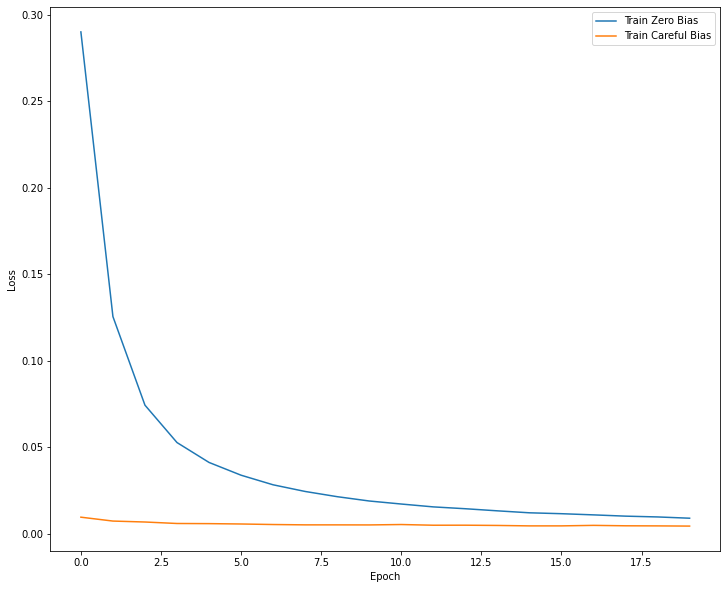

In [183]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

Clearly the model with a careful initialization converges faster. Therefore, we are going to use it.

### Training the model

We are going to train the model using cross validation. We will use Stratified k-fold in order to preserve the imbalance of the data set in each fold.

In [184]:
from sklearn.model_selection import KFold, StratifiedKFold

Y = train_df[['Class']]
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

n_samples = len(Y)

First, we write an auxiliary function for getting model name in each of the k iterations:

In [185]:
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

Then, another auxiliary function to plot the metrics:

In [186]:
def plot_metrics(history,color_num = 0, stack = 0, validation = 1):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    
    name = metric.replace("_"," ").capitalize()
    
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric],color = colors[color_num], 
             label='Train')
    
    if validation == 1:
      plt.plot(history.epoch, history.history['val_'+metric],
              colors[color_num], linestyle="--", label='Val')
    
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

    #show figures stacked (= 1) or side-to-side (stack /=1 )
    if stack == 1:
      plt.show()
    

And finally, a last auxiliary function for plotting the ROC curves:

In [187]:
def plot_roc_kfold(labels, predictions, val_labels, val_predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
  val_fp, val_tp, _ = sklearn.metrics.roc_curve(val_labels, val_predictions)

  plt.plot(100*fp, 100*tp, label='Train', linewidth=2, **kwargs)
  plt.plot(100*val_fp, 100*val_tp, label='Val', linewidth=2, linestyle='--', **kwargs)
  plt.legend()
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-1,100.5]) #Total
  #plt.ylim([-1,100.5]) #Total
  plt.xlim([-0.5,20]) #Better visualization
  plt.ylim([80,100.5]) #Better visualization
  plt.grid(True)
  #ax = plt.gca()
  #ax.set_aspect('equal')
  plt.show()

We are going to use two callbacks during each step of cross-validation: 

- ModelCheckpoint, to save the model that has the higher AUC during validation; 
- EarlyStopping, to stop training if the model does not improve the validation AUC after 10 epochs.  

After cross-validation, we calculate the mean and standard deviation of the metrics for all folds (accuracy, precision, recall and AUC). 

Before all this, we need to install a module to save the model weights.

In [188]:
pip install -q pyyaml h5py

And now we proceed with cross-validation.

------------------------------------------------------------------------
Training for fold 1 ...


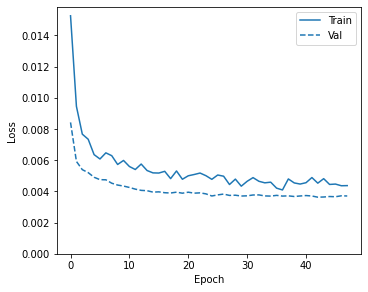

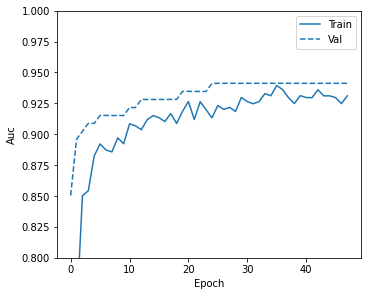

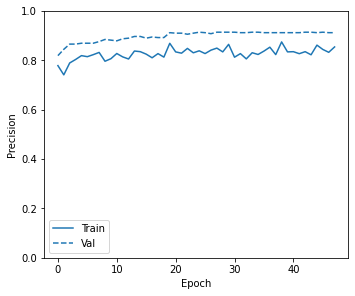

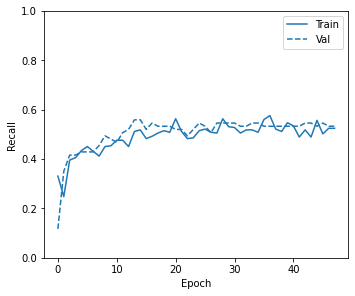

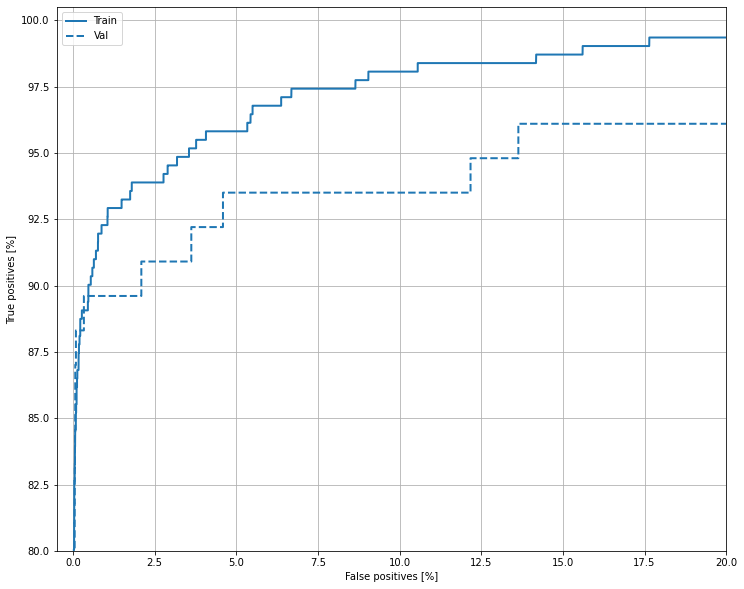

------------------------------------------------------------------------
Training for fold 2 ...


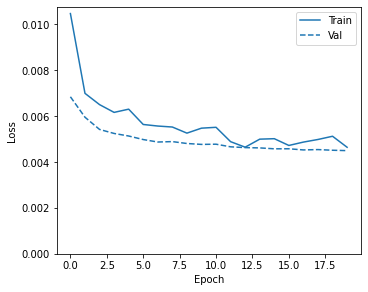

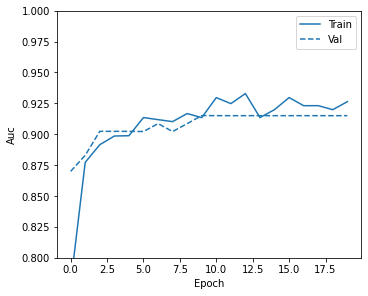

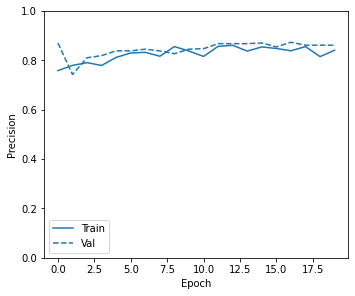

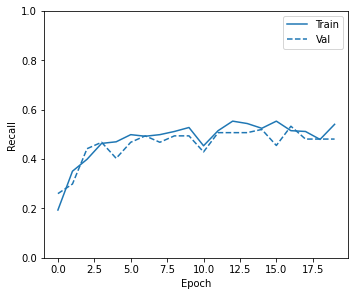

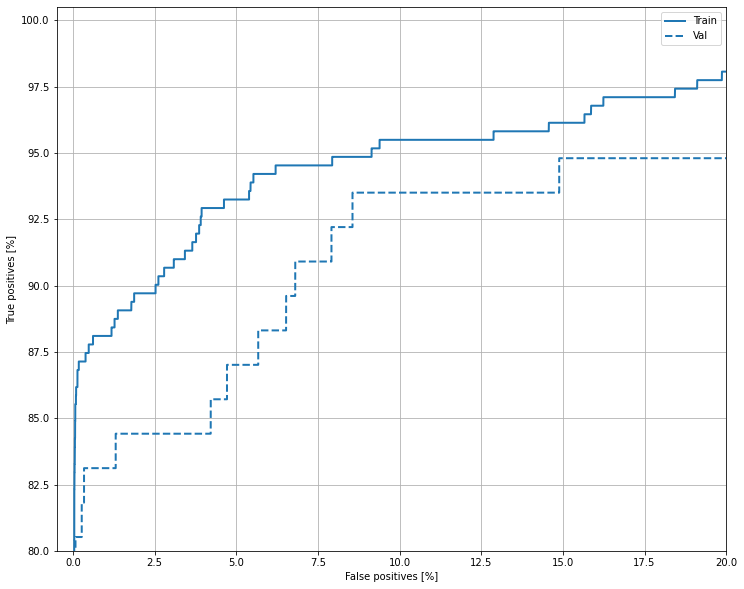

------------------------------------------------------------------------
Training for fold 3 ...


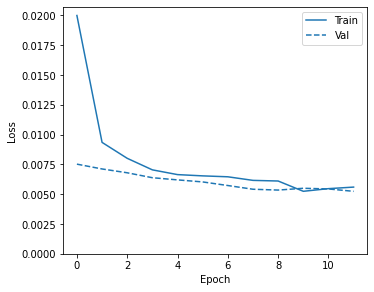

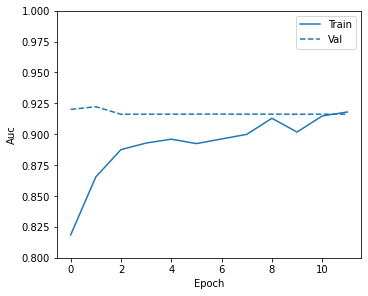

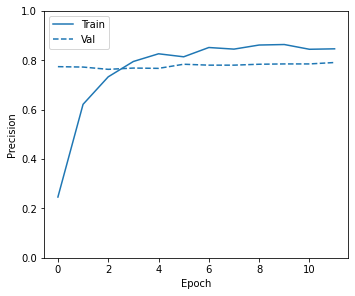

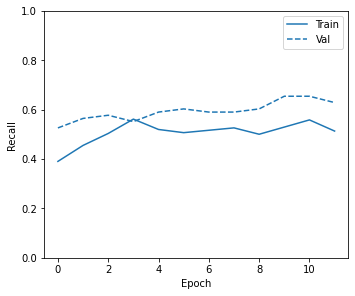

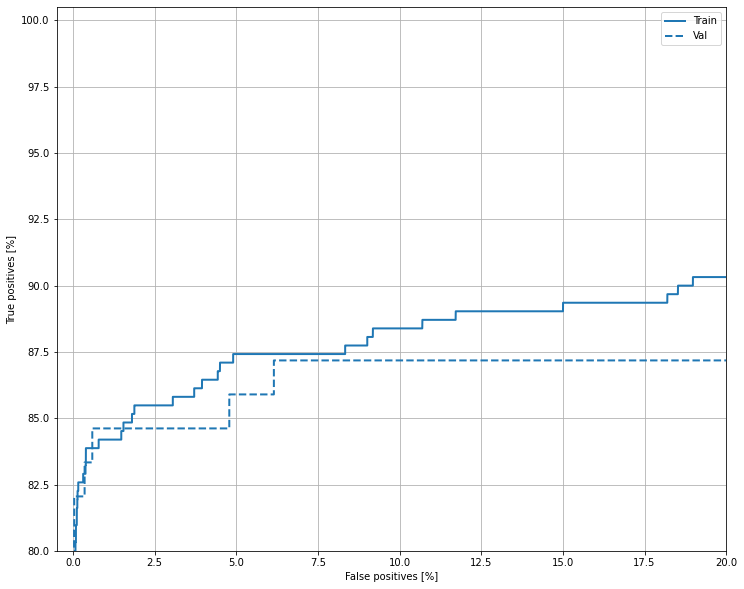

------------------------------------------------------------------------
Training for fold 4 ...


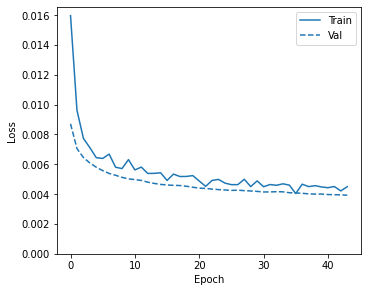

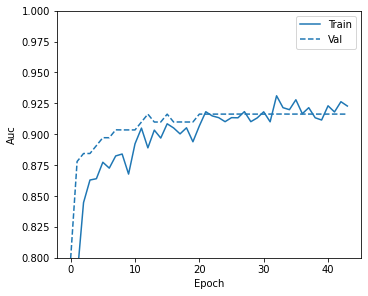

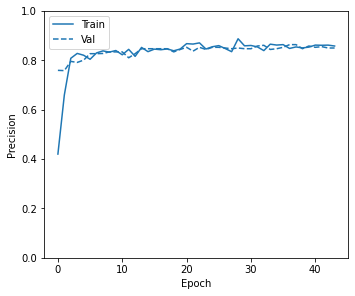

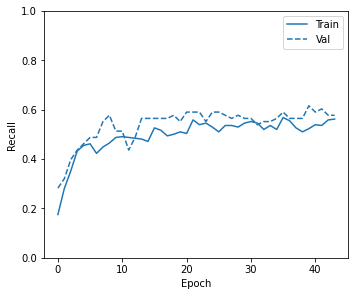

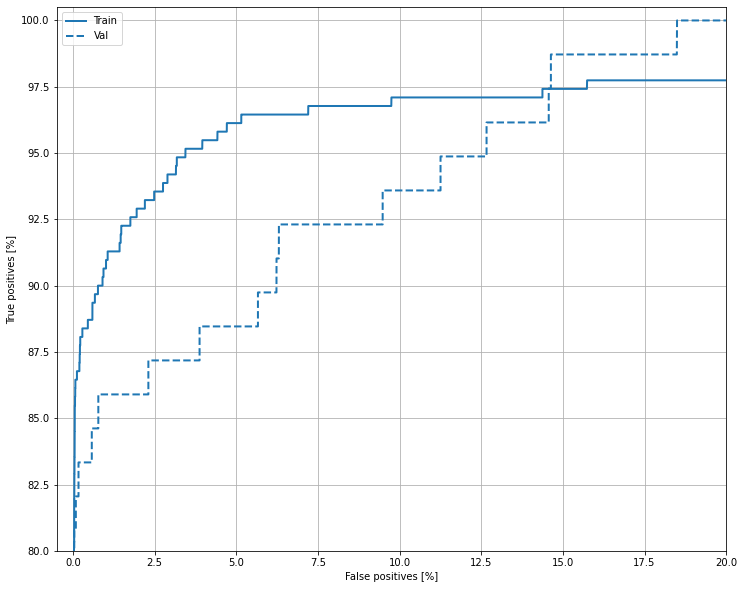

------------------------------------------------------------------------
Training for fold 5 ...


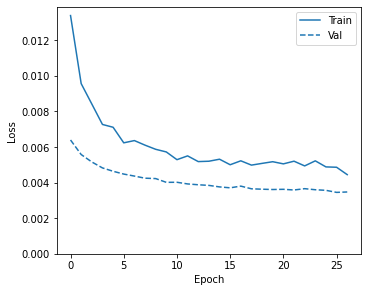

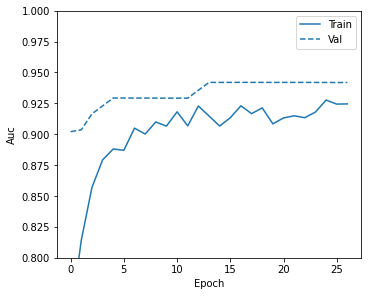

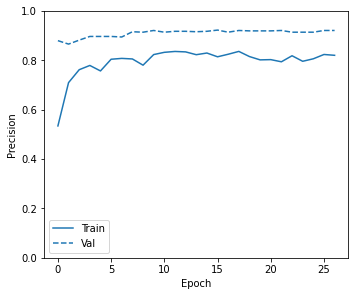

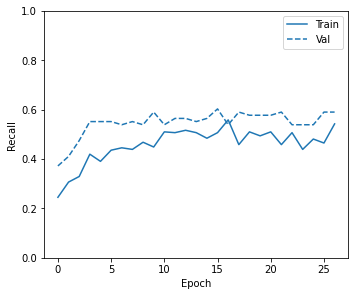

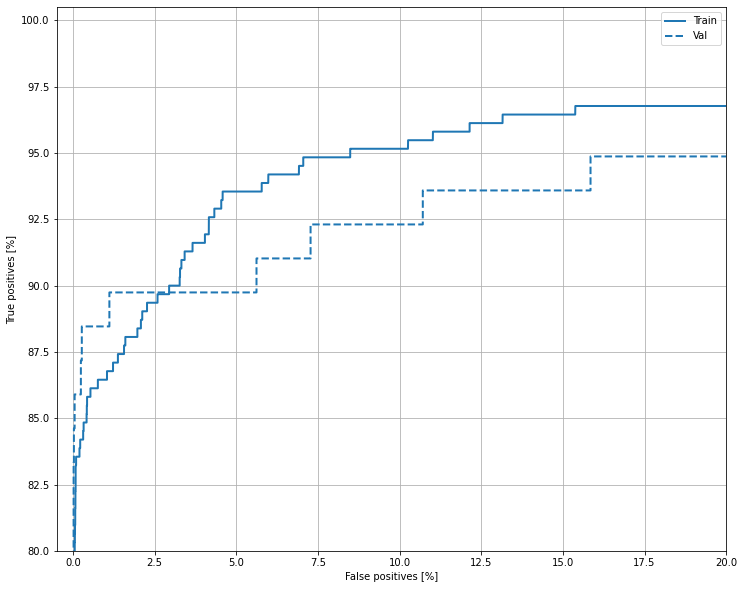

Accuracy:  0.9990519881248474 +/- 6.420173419309447e-05
Precision:  0.8567332267761231 +/- 0.05225951948645222
Recall:  0.5359640479087829 +/- 0.023864307859122236
AUC:  0.9274119973182678 +/- 0.011869822937196645


In [189]:
from keras import layers
from keras import models

VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_AUC = []

save_dir = '/content/'
fold_var = 1

EPOCHS = 100
BATCH_SIZE = 2048

for train_index, val_index in skf.split(np.zeros(n_samples),Y):
  train_data_kfold = train_df_features.iloc[train_index]
  val_data_kfold = train_df_features.iloc[val_index]

  train_labels_kfold = train_df_labels.iloc[train_index]
  val_labels_kfold = train_df_labels.iloc[val_index]

  # Convert the DataFrame into np arrays of labels and features.
  train_features_kfold = np.array(train_data_kfold)
  val_features_kfold = np.array(val_data_kfold)
  
  train_labels_kfold = np.array(train_labels_kfold)
  val_labels_kfold = np.array(val_labels_kfold)

  # Build the model.
  model = make_model(output_bias = initial_bias)
  
  # Create Callbacks save the best model
  # This saves the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
              monitor='val_auc', verbose=0, 
              save_best_only=True, mode='max')

  # This is for early stopping
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)
  
  #List of callbacks
  callbacks_list = [checkpoint, early_stopping]  

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit the Model  
  baseline_history_kfold = model.fit(
    train_features_kfold,
    train_labels_kfold,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    validation_data=(val_features_kfold, val_labels_kfold),
    verbose=0)

  #Plot history
  plot_metrics(baseline_history_kfold, color_num = 0, stack=1)

  # Load best model to evaluate the performance of the model
  model.load_weights(get_model_name(fold_var))

  baseline_results_kfold = model.evaluate(val_features_kfold, val_labels_kfold,
                                  batch_size=BATCH_SIZE, verbose=0)

  train_predictions_kfold = model.predict(train_features_kfold, batch_size=BATCH_SIZE)
  val_predictions_kfold = model.predict(val_features_kfold, batch_size=BATCH_SIZE)

  plot_roc_kfold(train_labels_kfold, train_predictions_kfold,
                 val_labels_kfold, val_predictions_kfold, color=colors[0])                                

  VALIDATION_ACCURACY.append(baseline_results_kfold[5])
  VALIDATION_PRECISION.append(baseline_results_kfold[6])
  VALIDATION_RECALL.append(baseline_results_kfold[7])
  VALIDATION_AUC.append(baseline_results_kfold[8])

  tf.keras.backend.clear_session()

  fold_var += 1

#Print the mean and standard deviation of the metrics.
print("Accuracy: ", np.mean(VALIDATION_ACCURACY), "+/-", np.std(VALIDATION_ACCURACY))
print("Precision: ", np.mean(VALIDATION_PRECISION), "+/-", np.std(VALIDATION_PRECISION))
print("Recall: ", np.mean(VALIDATION_RECALL), "+/-", np.std(VALIDATION_RECALL))
print("AUC: ", np.mean(VALIDATION_AUC), "+/-", np.std(VALIDATION_AUC))

The model is not overfitting, and seems to be generalizing well.

Knowing that, we can train using the whole training dataset.

In [190]:
model_baseline = make_model(output_bias = initial_bias)

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [191]:
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='auc', 
  verbose=0,
  patience=10,
  mode='max',
  restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_baseline.h5", 
            monitor='auc', verbose=0, 
            save_best_only=True, mode='max')
  
#List of callbacks
callbacks_list = [checkpoint, early_stopping]  

baseline_history = model_baseline.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    verbose=1)


Epoch 1/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0158 - tp: 121.0000 - fp: 279.0000 - tn: 272669.0000 - fn: 345.0000 - accuracy: 0.9977 - precision: 0.3025 - recall: 0.2597 - auc: 0.8006
Epoch 2/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0083 - tp: 135.0000 - fp: 69.0000 - tn: 227388.0000 - fn: 253.0000 - accuracy: 0.9986 - precision: 0.6618 - recall: 0.3479 - auc: 0.8690
Epoch 3/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0075 - tp: 172.0000 - fp: 64.0000 - tn: 227393.0000 - fn: 216.0000 - accuracy: 0.9988 - precision: 0.7288 - recall: 0.4433 - auc: 0.8759
Epoch 4/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0066 - tp: 183.0000 - fp: 51.0000 - tn: 227406.0000 - fn: 205.0000 - accuracy: 0.9989 - precision: 0.7821 - recall: 0.4716 - auc: 0.8943
Epoch 5/100
112/112 [==============================] - 1s 7ms/step - loss: 0.0061 - tp: 184.0000 - fp: 47.0000 - tn: 227410.0000 - fn: 204.0000

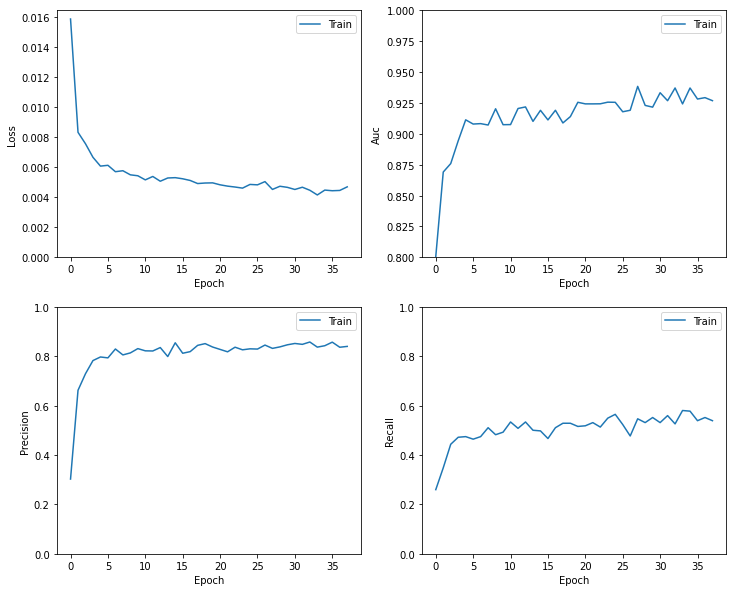

In [192]:
plot_metrics(baseline_history, color_num = 0, stack=0, validation = 0)

### Metrics evaluation

For this kind of problem, it is good to use a confusion matrix to get an idea of how well the model is classifying the positive and negative samples.

We begin by writing a function to plot the confusion matrix, using sklearn.

In [193]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Let's evaluate how the model performs.

Here is the confusion matrix for the training dataset.

loss :  0.00366917229257524
tp :  224.0
fp :  32.0
tn :  227425.0
fn :  164.0
accuracy :  0.9991397857666016
precision :  0.875
recall :  0.5773195624351501
auc :  0.9352487325668335

Legitimate Transactions Detected (True Negatives):  227425
Legitimate Transactions Incorrectly Detected (False Positives):  32
Fraudulent Transactions Missed (False Negatives):  164
Fraudulent Transactions Detected (True Positives):  224
Total Fraudulent Transactions:  388


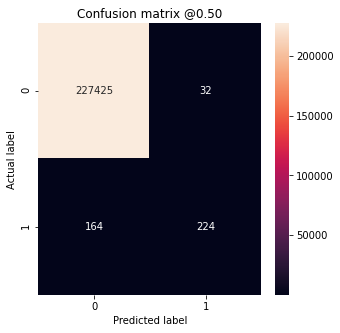

In [194]:
train_predictions_baseline = model_baseline.predict(train_features, batch_size=BATCH_SIZE)

train_baseline_results = model_baseline.evaluate(train_features, train_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_baseline.metrics_names, train_baseline_results):
  print(name, ': ', value)
print()

plot_cm(train_labels, train_predictions_baseline)

And here is the confusion matrix for the test dataset.

In [195]:
# Load best model to evaluate performance
model_baseline.load_weights("best_model_baseline.h5")

test_predictions_baseline = model_baseline.predict(test_features, batch_size=BATCH_SIZE)
train_predictions_baseline = model_baseline.predict(train_features, batch_size=BATCH_SIZE)

loss :  0.0033233778085559607
tp :  62.0
fp :  3.0
tn :  56855.0
fn :  42.0
accuracy :  0.999210000038147
precision :  0.9538461565971375
recall :  0.5961538553237915
auc :  0.942049503326416

Legitimate Transactions Detected (True Negatives):  56855
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  42
Fraudulent Transactions Detected (True Positives):  62
Total Fraudulent Transactions:  104


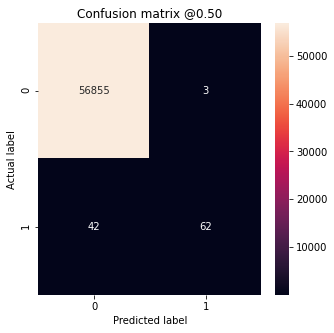

In [196]:
test_baseline_results = model_baseline.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_baseline.metrics_names, test_baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

The model has a very  high precision, which means that when it calls positive, it is right in most of the time. That is, few legitimate transactions were incorrectly classified as fraudulent. 

However, the not so high recall means that from all the positive samples, the model detected only a few of them, which means that many of the positive samples, or frauds, were incorrectly classified as legitimate.

These are not good results in the context of this problem. Although the number of legitimate transactions classified as frauds is low, the number of undetected frauds is too high. Both cases decrease the customer's happiness, but the second case is certainly much worse than the first, as it will also involve financial costs and decrease the customer's confidence in the bank's security system. Therefore, it would be better to increase the number of detected frauds (true positives), even if that results in more legitimate transactions being classified as frauds (false positives). 

###Plot the ROC curve

Plot the ROC curve and calculate the AUC.

In [197]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-1,100.5]) #Total
  #plt.ylim([-1,100.5]) #Total
  plt.xlim([-0.5,20]) #Better visualization
  plt.ylim([80,100.5]) #Better visualization
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

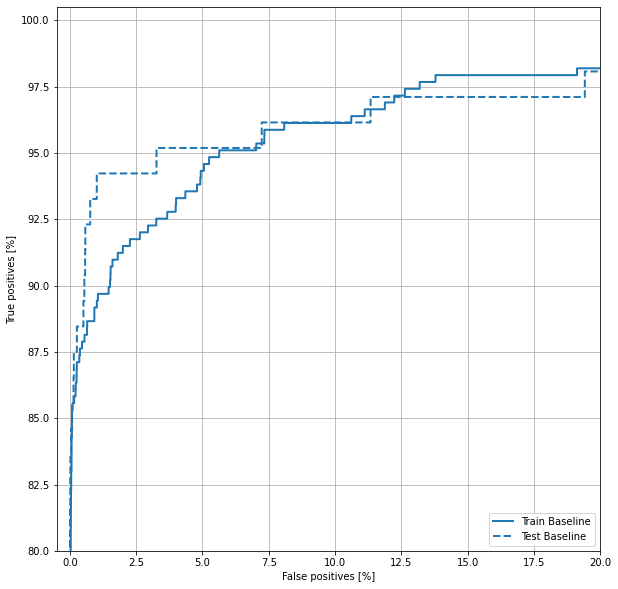

In [198]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

##Class weights

The fact that there are too few positive samples compared to the large amount of negative samples is a problem that cannot be neglected. A way to improve this model is to put weight on the positive samples, that is, forcing the model to "pay more attention" to the positive samples. This is done by passing Keras weights for each class through a parameter. 

Let's see how this improve our results. First, we need to define the weights:

In [199]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


The scaling by total/2 is needed to keep the loss to a similar magnitude. 

### Train a model with class weights

Let`s perform crossw validation.


------------------------------------------------------------------------
Training for fold 1 ...


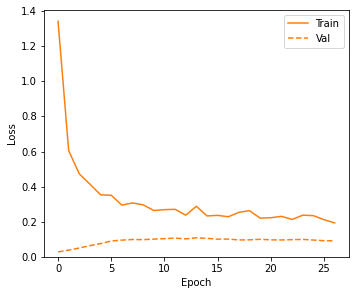

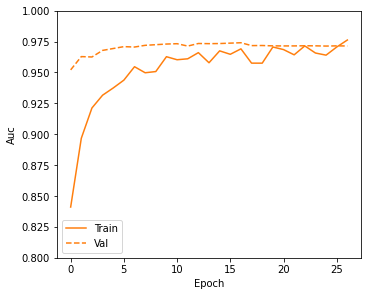

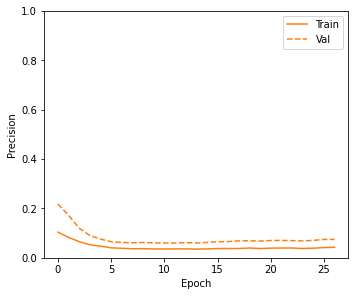

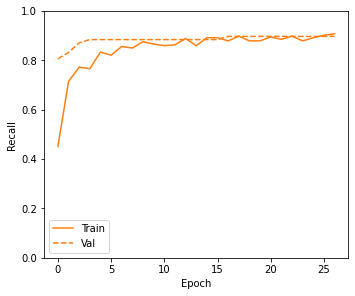

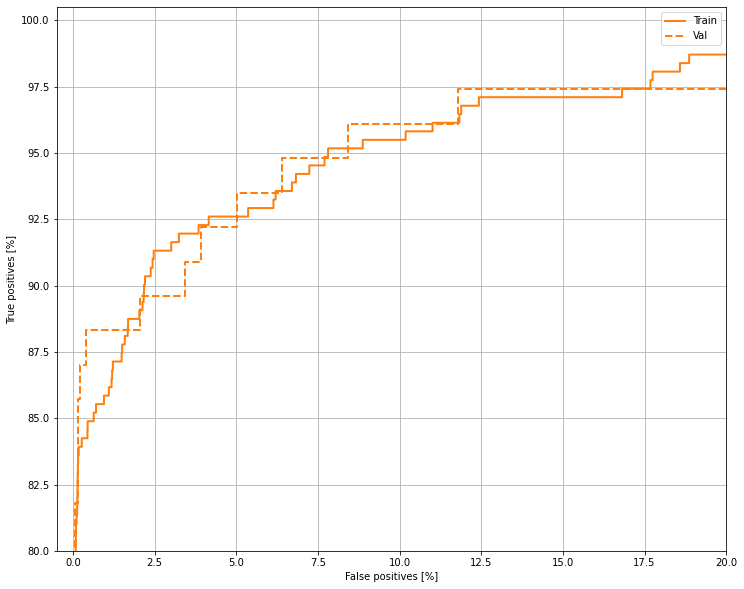

------------------------------------------------------------------------
Training for fold 2 ...


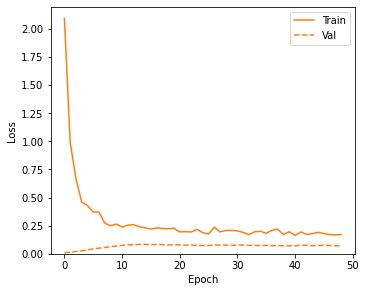

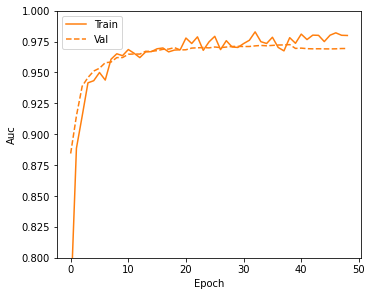

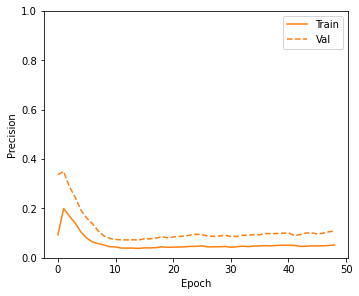

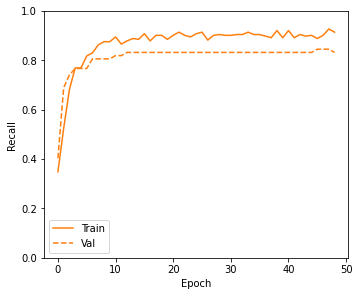

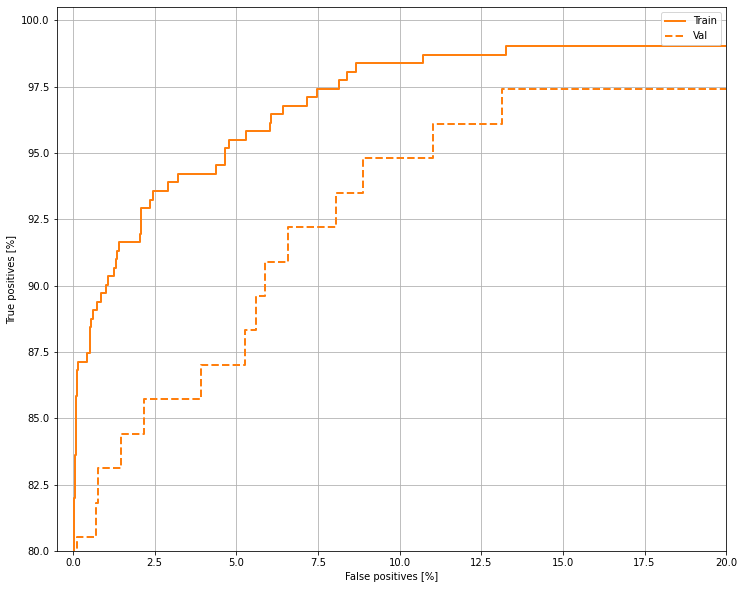

------------------------------------------------------------------------
Training for fold 3 ...


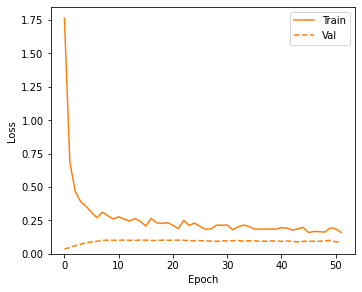

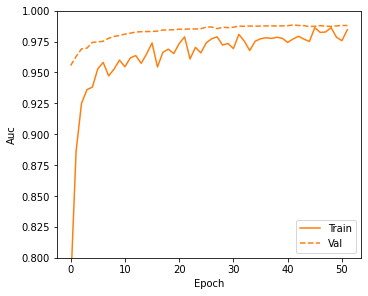

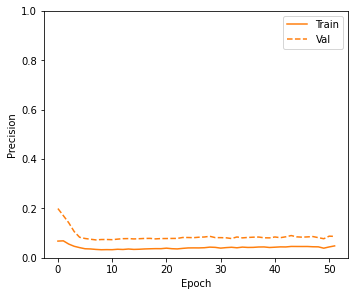

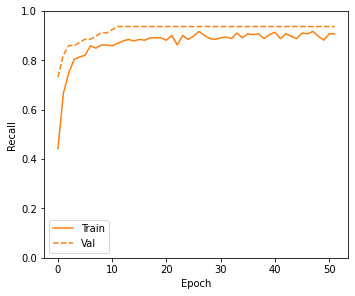

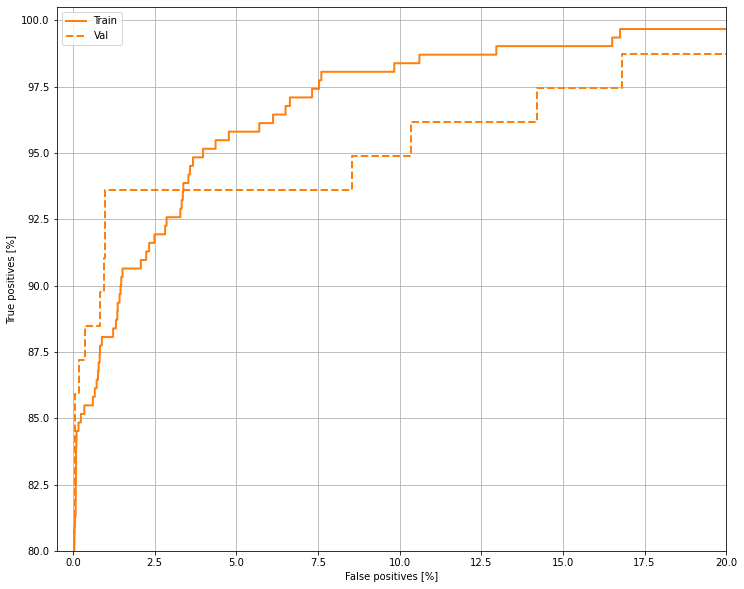

------------------------------------------------------------------------
Training for fold 4 ...


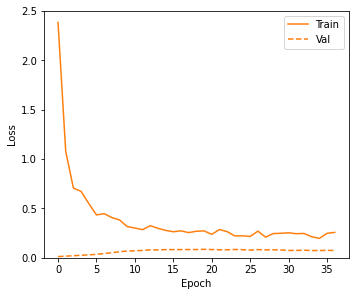

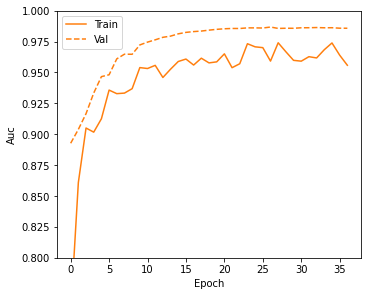

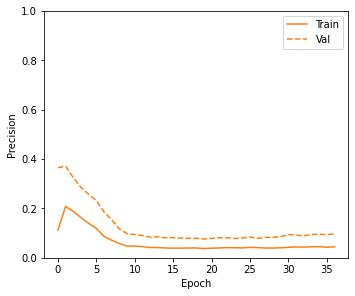

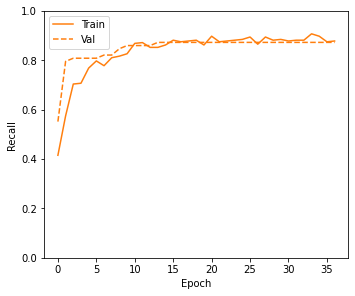

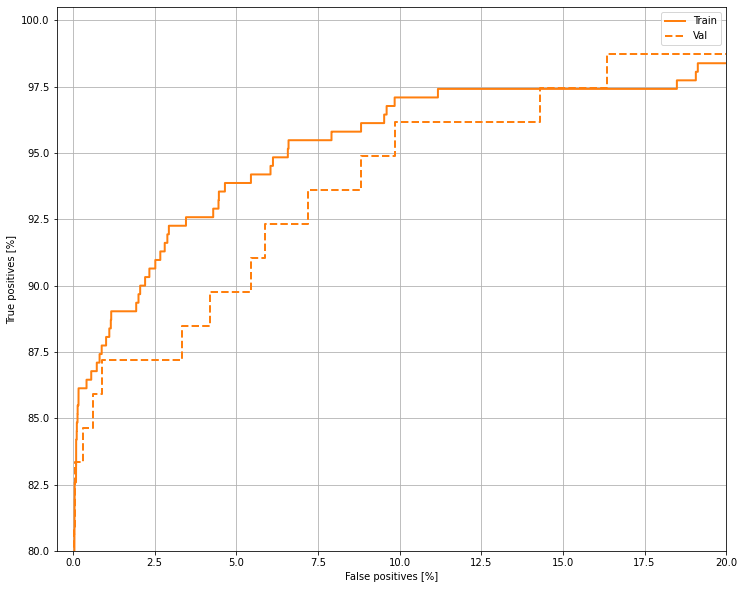

------------------------------------------------------------------------
Training for fold 5 ...


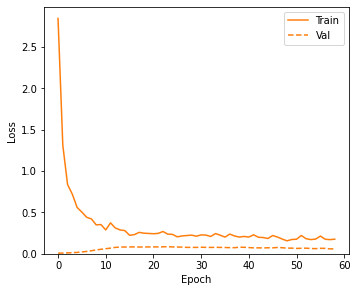

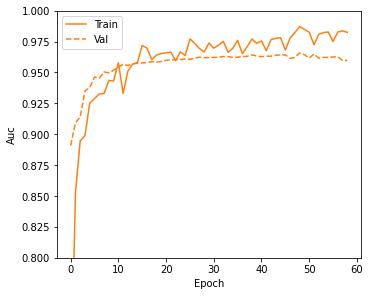

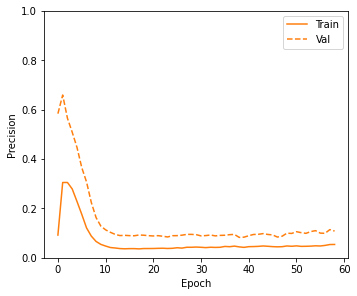

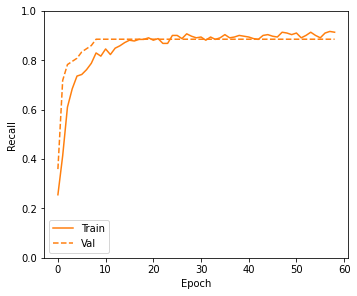

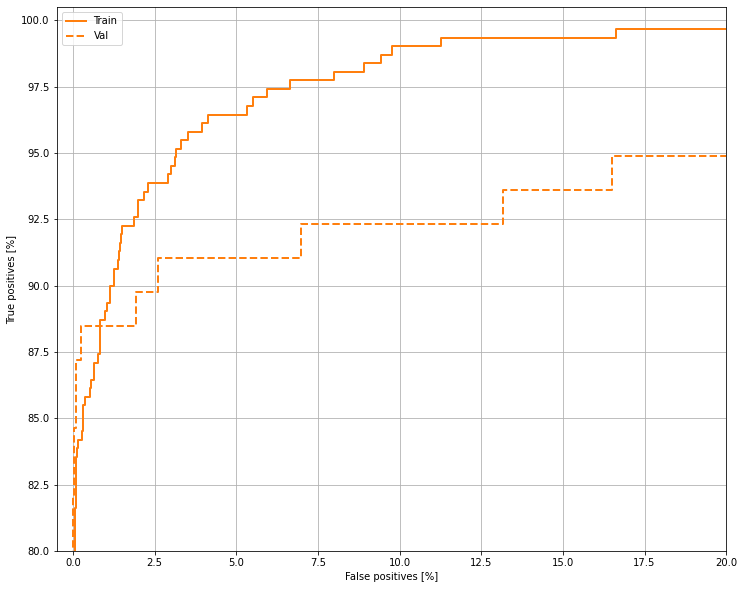

Accuracy:  0.9830498814582824 +/- 0.0031313935437732596
Precision:  0.08466181010007859 +/- 0.012834115375434482
Recall:  0.8839160799980164 +/- 0.03400084383455807
AUC:  0.9775667309761047 +/- 0.008686982076218186


In [200]:
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_AUC = []

save_dir = '/content/'
fold_var = 1

EPOCHS = 100
BATCH_SIZE = 2048

scaler = StandardScaler()

for train_index, val_index in skf.split(np.zeros(n_samples),Y):
  train_data_kfold = train_df_features.iloc[train_index]
  val_data_kfold = train_df_features.iloc[val_index]

  train_labels_kfold = train_df_labels.iloc[train_index]
  val_labels_kfold = train_df_labels.iloc[val_index]

  # Convert the DataFrame into np arrays of labels and features.
  train_features_kfold = np.array(train_data_kfold)
  val_features_kfold = np.array(val_data_kfold)
  
  train_labels_kfold = np.array(train_labels_kfold)
  val_labels_kfold = np.array(val_labels_kfold)

  # Build the model.
  model = make_model(output_bias = initial_bias)
  
  # Create Callbacks save the best model
  # This saves the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
              monitor='val_auc', verbose=0, 
              save_best_only=True, mode='max')

  # This is for early stopping
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)
  
  #List of callbacks
  callbacks_list = [checkpoint, early_stopping]  

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit the Model  
  weighted_history_kfold = model.fit(
    train_features_kfold,
    train_labels_kfold,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    validation_data=(val_features_kfold, val_labels_kfold),
    class_weight=class_weight, # Here we define the class weights
    verbose=0)

  #PLOT HISTORY
  plot_metrics(weighted_history_kfold, color_num = 1, stack=1)

  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights(get_model_name(fold_var))

  weighted_results_kfold = model.evaluate(val_features_kfold, val_labels_kfold,
                                  batch_size=BATCH_SIZE, verbose=0)
  
  train_predictions_kfold = model.predict(train_features_kfold, batch_size=BATCH_SIZE)
  val_predictions_kfold = model.predict(val_features_kfold, batch_size=BATCH_SIZE)

  plot_roc_kfold(train_labels_kfold, train_predictions_kfold,
                 val_labels_kfold, val_predictions_kfold, color=colors[1])    

  VALIDATION_ACCURACY.append(weighted_results_kfold[5])
  VALIDATION_PRECISION.append(weighted_results_kfold[6])
  VALIDATION_RECALL.append(weighted_results_kfold[7])
  VALIDATION_AUC.append(weighted_results_kfold[8])

  tf.keras.backend.clear_session()

  fold_var += 1

print("Accuracy: ", np.mean(VALIDATION_ACCURACY), "+/-", np.std(VALIDATION_ACCURACY))
print("Precision: ", np.mean(VALIDATION_PRECISION), "+/-", np.std(VALIDATION_PRECISION))
print("Recall: ", np.mean(VALIDATION_RECALL), "+/-", np.std(VALIDATION_RECALL))
print("AUC: ", np.mean(VALIDATION_AUC), "+/-", np.std(VALIDATION_AUC))

As the model is not overfitting and generalizes well for all data, we can train on the whole training dataset.

In [201]:
model_weighted = make_model(output_bias = initial_bias)

model_weighted.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [202]:
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='auc', 
  verbose=0,
  patience=10,
  mode='max',
  restore_best_weights=True)

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_weighted.h5", 
            monitor='auc', verbose=0, 
            save_best_only=True, mode='max')
  
#List of callbacks
callbacks_list = [checkpoint, early_stopping]  

weighted_history = model_weighted.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    class_weight = class_weight, # Here we define the class weights
    verbose=1)

Epoch 1/100
112/112 [==============================] - 1s 7ms/step - loss: 1.6074 - tp: 178.0000 - fp: 2702.0000 - tn: 270246.0000 - fn: 288.0000 - accuracy: 0.9891 - precision: 0.0618 - recall: 0.3820 - auc: 0.7642
Epoch 2/100
112/112 [==============================] - 1s 7ms/step - loss: 0.7977 - tp: 226.0000 - fp: 3409.0000 - tn: 224048.0000 - fn: 162.0000 - accuracy: 0.9843 - precision: 0.0622 - recall: 0.5825 - auc: 0.8713
Epoch 3/100
112/112 [==============================] - 1s 7ms/step - loss: 0.5918 - tp: 267.0000 - fp: 4889.0000 - tn: 222568.0000 - fn: 121.0000 - accuracy: 0.9780 - precision: 0.0518 - recall: 0.6881 - auc: 0.8925
Epoch 4/100
112/112 [==============================] - 1s 7ms/step - loss: 0.3948 - tp: 315.0000 - fp: 5920.0000 - tn: 221537.0000 - fn: 73.0000 - accuracy: 0.9737 - precision: 0.0505 - recall: 0.8119 - auc: 0.9320
Epoch 5/100
112/112 [==============================] - 1s 7ms/step - loss: 0.4013 - tp: 312.0000 - fp: 6671.0000 - tn: 220786.0000 - fn: 

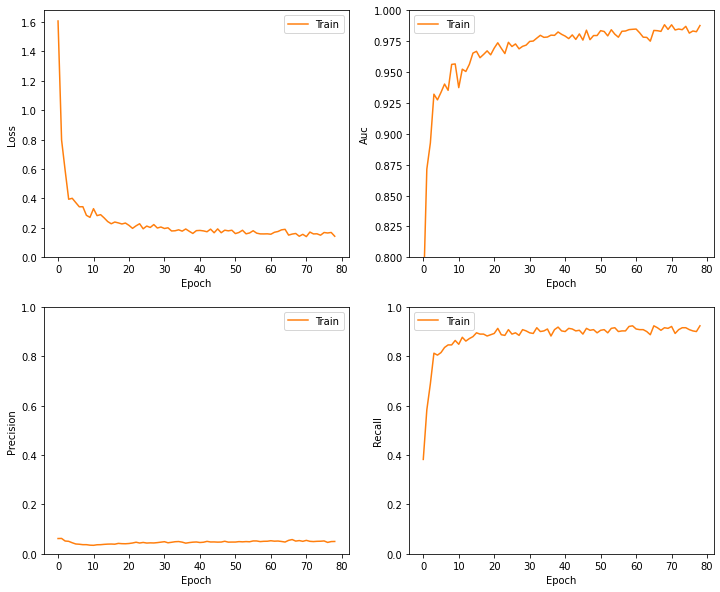

In [203]:
plot_metrics(weighted_history, color_num = 1, stack=0, validation = 0)

### Evaluate metrics and confusion matrix:
Plotting the confusion matrix for the training dataset...

loss :  0.079800084233284
tp :  353.0
fp :  3244.0
tn :  224213.0
fn :  35.0
accuracy :  0.9856086373329163
precision :  0.09813733398914337
recall :  0.9097937941551208
auc :  0.9943675994873047

Legitimate Transactions Detected (True Negatives):  224213
Legitimate Transactions Incorrectly Detected (False Positives):  3244
Fraudulent Transactions Missed (False Negatives):  35
Fraudulent Transactions Detected (True Positives):  353
Total Fraudulent Transactions:  388


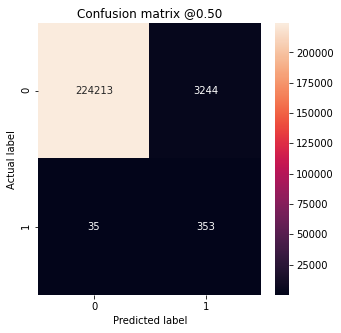

In [204]:
train_predictions_weighted = model_weighted.predict(train_features, batch_size=BATCH_SIZE)

weighted_results_train = model_weighted.evaluate(train_features, train_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_weighted.metrics_names, weighted_results_train):
  print(name, ': ', value)
print()

plot_cm(train_labels, train_predictions_weighted)

...and for the test dataset.

loss :  0.07203052192926407
tp :  98.0
fp :  762.0
tn :  56096.0
fn :  6.0
accuracy :  0.9865173101425171
precision :  0.11395348608493805
recall :  0.942307710647583
auc :  0.9796572327613831

Legitimate Transactions Detected (True Negatives):  56096
Legitimate Transactions Incorrectly Detected (False Positives):  762
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  98
Total Fraudulent Transactions:  104


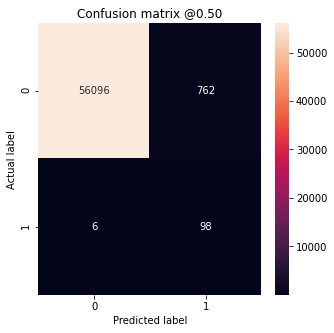

In [205]:
#Load best model to evaluate performance
model_weighted.load_weights("best_model_weighted.h5")

train_predictions_weighted = model_weighted.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = model_weighted.predict(test_features, batch_size=BATCH_SIZE)

weighted_results = model_weighted.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_weighted.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

With the class weights, the model could detect more fradulent transactions, with a high AUC. This is a nice result, but comes with the downside of classifying a relatively large number of legitimate transactions as fraudulent. But, as discussed before, this is better than missing positive samples. This is all reflected by the high recall and low precision.


###Plot the ROC curve

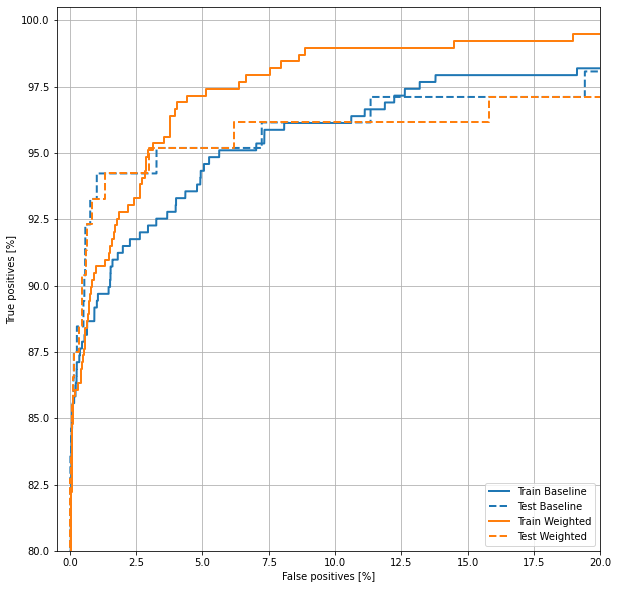

In [206]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right')

## Random undersampling 

A third alternative to solve the imbalance problem is to implement "Random Under Sampling", which consists of removing data from the majority class (non-fraud) in order to have a balanced dataset:

1. First, we determine how many fraud samples there are (we already did this, there are 492 fraud samples).
2. Then, we bring that same amount of non-fraud transactions (chosen randomly) and put them together into a new dataframe, which will have a 50/50 ratio of fraud and non-fraud transactions. 

The problem with doing the Random under-sampling is the risk to lose information, as we are taking only 492 non-fraud samples from a set of 284,314.

We begin by creating the undersampling the original training dataset:

In [207]:
# amount of fraud classes in train_df rows.
fraud_train_df = train_df.loc[train_df['Class'] == 1]
non_fraud_train_df = train_df.loc[train_df['Class'] == 0]
n_fraud_train = len(fraud_train_df.index) #Number of positive samples
non_fraud_train_df = non_fraud_train_df.sample(n=n_fraud_train, random_state=42)

normal_distributed_train_df = pd.concat([fraud_train_df, non_fraud_train_df])

# Shuffle dataframe rows
train_under_df = normal_distributed_train_df.sample(frac=1, random_state=42)

neg_under, pos_under = np.bincount(train_under_df['Class'])
total_under = neg_under + pos_under
print('Examples:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under, neg_under, 100 * neg_under / total_under, pos_under, 100 * pos_under / total_under))

Examples:
  Total: 776
  Negative: 388 (50.00% of total)
  Positive: 388 (50.00% of total)



Now we undersample the test dataset:

In [208]:
fraud_test_df = test_df.loc[test_df['Class'] == 1]
non_fraud_test_df = test_df.loc[test_df['Class'] == 0]
n_fraud_test = len(fraud_test_df.index) #Number of positive samples
non_fraud_test_df = non_fraud_test_df.sample(n=n_fraud_test, random_state=42)

normal_distributed_test_df = pd.concat([fraud_test_df, non_fraud_test_df])

# Shuffle dataframe rows
test_under_df = normal_distributed_test_df.sample(frac=1, random_state=42)

neg_under, pos_under = np.bincount(test_under_df['Class'])
total_under = neg_under + pos_under
print('Examples:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under, neg_under, 100 * neg_under / total_under, pos_under, 100 * pos_under / total_under))

Examples:
  Total: 208
  Negative: 104 (50.00% of total)
  Positive: 104 (50.00% of total)



This test dataset is balanced, but the real problem is not. Therefore, we must keep the original test set, which is imbalanced, so we can test the model on it.

In [209]:
neg_under, pos_under = np.bincount(test_df['Class'])
total_under = neg_under + pos_under
print('Examples:\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under, neg_under, 100 * neg_under / total_under, pos_under, 100 * pos_under / total_under))

Examples:
  Total: 56962
  Negative: 56858 (99.82% of total)
  Positive: 104 (0.18% of total)



In [210]:
train_under_df_features = train_under_df.copy() #Balanced train dataset
test_under_df_features = test_under_df.copy() #Balanced test dataset
test_bal_df_features = test_df.copy() #Imbalanced test dataset

train_under_df_labels = train_under_df_features.pop('Class')
test_under_df_labels = test_under_df_features.pop('Class')
test_bal_df_labels = test_bal_df_features.pop('Class')

# Count the negatives and positives
neg_under_train, pos_under_train = np.bincount(train_under_df_labels)
total_under_train = neg_under_train + pos_under_train

neg_under_test, pos_under_test = np.bincount(test_under_df_labels)
total_under_test = neg_under_test + pos_under_test

neg_test, pos_test = np.bincount(test_bal_df_labels)
total_test = neg_test + pos_test

print('Train (Balanced):\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under_train, neg_under_train, 100 * neg_under_train / total_under_train,
    pos_under_train, 100 * pos_under_train / total_under_train))


print('Test (Balanced):\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_under_test, neg_under_test, 100 * neg_under_test / total_under_test, 
    pos_under_test, 100 * pos_under_test / total_under_test))

print('Test (Imbalanced):\n  Total: {}\n  Negative: {} ({:.2f}% of total)\n  Positive: {} ({:.2f}% of total)\n'.format(
    total_test, neg_test, 100 * neg_test / total_test, pos_test, 100 * pos_test / total_test))

Train (Balanced):
  Total: 776
  Negative: 388 (50.00% of total)
  Positive: 388 (50.00% of total)

Test (Balanced):
  Total: 208
  Negative: 104 (50.00% of total)
  Positive: 104 (50.00% of total)

Test (Imbalanced):
  Total: 56962
  Negative: 56858 (99.82% of total)
  Positive: 104 (0.18% of total)



Here we scale the data as before.

In [211]:
scaler = StandardScaler()

train_under_scaled = StandardScaler().fit_transform(train_under_df_features.values)

train_under_df_features = pd.DataFrame(train_under_scaled, index=train_under_df_features.index, 
                                 columns=train_under_df_features.columns)                                        

test_under_scaled = StandardScaler().fit_transform(test_under_df_features.values)

test_under_df_features = pd.DataFrame(test_under_scaled, index=test_under_df_features.index, 
                                columns=test_under_df_features.columns)   

test_bal_scaled = StandardScaler().fit_transform(test_bal_df_features.values)

test_bal_df_features = pd.DataFrame(test_bal_scaled, index=test_bal_df_features.index, 
                                columns=test_bal_df_features.columns)                  

print('Training features shape (Balanced):', train_under_df_features.shape)
print('Training labels shape (Balanced):', train_under_df_labels.shape, "\n")

print('Test features shape (Balanced):', test_under_df_features.shape)
print('Test labels shape (Balanced):', test_under_df_labels.shape, "\n")

print('Test features shape (Imbalanced):', test_bal_df_features.shape)
print('Test labels shape (Imbalanced):', test_bal_df_labels.shape)

Training features shape (Balanced): (776, 30)
Training labels shape (Balanced): (776,) 

Test features shape (Balanced): (208, 30)
Test labels shape (Balanced): (208,) 

Test features shape (Imbalanced): (56962, 30)
Test labels shape (Imbalanced): (56962,)


In [212]:
train_under_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02,7.760000e+02
mean,2.832786e-17,2.861400e-18,2.231892e-17,-6.438149e-17,6.295079e-18,6.295079e-17,2.746944e-17,1.121669e-16,1.659612e-17,-8.584199e-18,-3.261995e-17,-1.459314e-16,2.203278e-17,1.917138e-17,3.977345e-17,3.934424e-17,-1.087332e-16,5.722799e-18,5.837255e-17,-2.403576e-17,3.834275e-17,6.295079e-18,-8.584199e-19,-3.104619e-17,-2.661102e-17,2.782711e-17,-3.862889e-18,-2.002980e-18,-6.581219e-18,-3.476600e-17
std,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00,1.000645e+00
min,-1.845437e+00,-4.951312e+00,-2.746185e+00,-4.353820e+00,-1.866202e+00,-4.704874e+00,-3.233798e+00,-6.816962e+00,-7.932751e+00,-5.229570e+00,-4.731567e+00,-1.569234e+00,-3.410209e+00,-3.405420e+00,-3.403059e+00,-3.570918e+00,-3.305551e+00,-3.641537e+00,-3.471870e+00,-3.166739e+00,-3.525743e+00,-7.647964e+00,-7.162423e+00,-6.879066e+00,-3.655827e+00,-3.782504e+00,-2.875400e+00,-7.265721e+00,-4.594973e+00,-4.592052e-01
25%,-8.669717e-01,-6.317985e-02,-5.425638e-01,-2.433638e-01,-7.253785e-01,-4.155661e-02,-5.043422e-01,-4.171549e-02,-9.252418e-02,-4.321087e-01,-3.943554e-01,-7.546964e-01,-5.275916e-01,-7.041950e-01,-6.895395e-01,-5.357208e-01,-4.476599e-01,-3.688203e-01,-3.349658e-01,-6.108579e-01,-3.579972e-01,-1.850980e-01,-4.239409e-01,-2.957424e-01,-6.081158e-01,-5.109458e-01,-6.255844e-01,-1.338277e-01,-2.605505e-01,-4.539874e-01
50%,-1.148511e-01,2.816891e-01,-2.505678e-01,3.482460e-01,-3.101939e-01,2.756587e-01,7.719171e-03,3.684087e-01,-2.621597e-02,2.558468e-01,4.449187e-01,-3.069754e-01,4.967091e-01,2.557637e-02,5.496617e-01,4.794248e-02,4.093473e-01,4.737023e-01,3.293966e-01,-1.175867e-01,-1.572674e-01,-8.665137e-02,4.976476e-02,-5.781494e-02,7.780310e-02,2.221653e-02,-7.256621e-02,-2.300566e-02,-3.584751e-02,-3.880536e-01
75%,9.590412e-01,6.116060e-01,2.382335e-01,6.149343e-01,6.269528e-01,4.765188e-01,4.438613e-01,5.236627e-01,1.196875e-01,6.248444e-01,6.315456e-01,6.235423e-01,7.238599e-01,6.652894e-01,7.660208e-01,6.972759e-01,6.865312e-01,6.061362e-01,6.064255e-01,5.017740e-01,2.410640e-01,8.871469e-02,4.506293e-01,1.968487e-01,7.305825e-01,5.778788e-01,5.842108e-01,3.809894e-01,4.260383e-01,1.509160e-02
max,1.703939e+00,8.191338e-01,5.370795e+00,1.073677e+00,3.137955e+00,2.629848e+00,4.039089e+00,1.490829e+00,3.784399e+00,2.528977e+00,2.246342e+00,3.644538e+00,1.162704e+00,2.962472e+00,1.275394e+00,2.545578e+00,1.331541e+00,1.698589e+00,1.924819e+00,3.886199e+00,1.035662e+01,8.841679e+00,6.776375e+00,6.269012e+00,2.215356e+00,3.325120e+00,5.837459e+00,2.611579e+00,4.310064e+00,9.624737e+00


In [213]:
test_under_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02,2.080000e+02
mean,-1.107554e-16,-4.270089e-18,5.124106e-17,4.270089e-17,-2.989062e-17,-3.416071e-17,9.394195e-17,-5.978124e-17,-1.708035e-17,3.416071e-17,2.135044e-17,3.843080e-17,-3.949832e-17,-3.416071e-17,6.475189e-17,3.416071e-17,3.416071e-17,3.202566e-18,-2.882310e-17,5.551115e-17,3.416071e-17,1.708035e-17,5.124106e-17,1.281027e-17,1.587939e-17,-2.241796e-17,3.202566e-18,-1.281027e-17,-4.803850e-18,4.376841e-17
std,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00,1.002413e+00
min,-1.756511e+00,-4.954609e+00,-2.872065e+00,-3.859196e+00,-2.130503e+00,-4.431430e+00,-3.152591e+00,-6.526130e+00,-8.709028e+00,-4.534218e+00,-4.807371e+00,-1.632681e+00,-3.167884e+00,-2.956481e+00,-3.019865e+00,-4.728170e+00,-3.469152e+00,-3.418744e+00,-3.406976e+00,-2.725918e+00,-4.471509e+00,-1.001630e+01,-2.054497e+00,-9.939019e+00,-2.866292e+00,-6.632604e+00,-2.632638e+00,-5.203762e+00,-4.054790e+00,-4.291936e-01
25%,-8.088827e-01,-2.272577e-01,-5.707196e-01,-2.689179e-01,-6.845668e-01,-5.875617e-02,-5.717528e-01,-9.231518e-02,-1.528964e-01,-4.054886e-01,-3.888083e-01,-7.551444e-01,-5.028382e-01,-7.806338e-01,-7.526511e-01,-5.001181e-01,-3.131592e-01,-3.052133e-01,-2.496521e-01,-5.891092e-01,-3.847467e-01,-2.102665e-01,-6.845130e-01,-2.063099e-02,-6.353286e-01,-4.356580e-01,-6.636910e-01,-1.896232e-01,-1.622879e-01,-4.216833e-01
50%,-1.997805e-01,2.591040e-01,-2.073977e-01,3.136537e-01,-3.476698e-01,2.548948e-01,7.876958e-02,3.740052e-01,-1.753684e-02,2.513907e-01,4.353715e-01,-2.589689e-01,4.782141e-01,3.266126e-02,5.361735e-01,7.323003e-02,3.917775e-01,4.620232e-01,3.111933e-01,-9.975700e-02,-1.290822e-01,-4.619819e-02,-1.137599e-01,7.885783e-02,2.002914e-01,9.813255e-02,-7.677143e-02,-7.721990e-02,4.025598e-02,-3.458401e-01
75%,8.727905e-01,6.809059e-01,3.847715e-01,6.269317e-01,5.108895e-01,4.919643e-01,5.274785e-01,5.400070e-01,1.335894e-01,6.114617e-01,6.370540e-01,5.485985e-01,7.152957e-01,7.212569e-01,7.680876e-01,7.137927e-01,6.810426e-01,5.718533e-01,5.909612e-01,5.664074e-01,2.099851e-01,2.138278e-01,5.866673e-01,1.954608e-01,7.600949e-01,5.580737e-01,7.791853e-01,3.130049e-01,3.820753e-01,-7.970260e-03
max,1.821050e+00,9.168319e-01,5.642927e+00,1.188943e+00,2.904770e+00,3.393087e+00,3.264430e+00,1.026869e+00,4.541479e+00,1.856868e+00,1.418428e+00,3.298322e+00,1.017373e+00,2.844992e+00,1.444818e+00,2.062577e+00,1.509871e+00,1.635221e+00,2.055695e+00,3.396594e+00,8.272096e+00,3.144514e+00,6.470049e+00,1.912708e+00,1.902466e+00,2.275813e+00,2.685702e+00,3.002492e+00,3.191427e+00,6.920088e+00


In [214]:
test_bal_df_features.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04,5.696200e+04
mean,-5.244528e-17,4.928781e-17,-1.120709e-18,-6.020643e-18,4.208019e-18,-2.176417e-17,9.449038e-18,2.182069e-17,1.083872e-17,-6.602438e-17,1.283650e-17,1.509351e-17,4.404873e-19,4.242322e-17,1.630193e-17,2.953312e-18,-2.383699e-17,3.473223e-17,-2.014547e-17,-2.041639e-17,-2.598486e-17,9.499227e-19,-2.341600e-17,7.831380e-18,2.414299e-17,-1.126702e-17,2.642047e-17,4.504312e-17,1.056244e-17,-2.581383e-16
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-1.999619e+00,-1.911180e+01,-3.842493e+01,-3.212516e+01,-3.681834e+00,-7.973013e+01,-1.261384e+01,-2.829666e+01,-5.954578e+01,-1.002868e+01,-2.099940e+01,-3.994167e+00,-1.817714e+01,-5.815709e+00,-1.906398e+01,-4.922824e+00,-1.612446e+01,-2.777787e+01,-1.105632e+01,-8.859844e+00,-6.747278e+01,-4.637038e+01,-1.510119e+01,-4.459335e+01,-4.582027e+00,-1.339160e+01,-5.249256e+00,-5.272745e+01,-4.550856e+01,-3.187748e-01
25%,-8.539903e-01,-4.739412e-01,-3.628357e-01,-5.905376e-01,-5.974657e-01,-4.836124e-01,-5.685534e-01,-4.267438e-01,-1.649411e-01,-5.792729e-01,-4.915771e-01,-7.424581e-01,-4.046996e-01,-6.565363e-01,-4.394682e-01,-6.360801e-01,-5.275651e-01,-5.754770e-01,-5.974971e-01,-5.624014e-01,-2.613662e-01,-3.027893e-01,-7.485351e-01,-2.670573e-01,-5.881452e-01,-6.079642e-01,-6.777751e-01,-1.701640e-01,-1.490895e-01,-2.989499e-01
50%,-2.119372e-01,1.050257e-02,4.069056e-02,1.204126e-01,-1.213293e-02,-4.243916e-02,-2.031020e-01,2.690446e-02,2.267335e-02,-4.501120e-02,-9.021792e-02,-3.670715e-02,1.371007e-01,-1.810541e-02,5.608571e-02,4.869044e-02,7.872962e-02,-7.719186e-02,-2.577444e-03,6.281650e-03,-7.765246e-02,-3.864017e-02,7.523445e-03,-1.857139e-02,6.562901e-02,2.955261e-02,-1.022995e-01,-4.038502e-04,3.875844e-02,-2.393309e-01
75%,9.408505e-01,6.753138e-01,4.885778e-01,6.810700e-01,5.254885e-01,4.290140e-01,2.906461e-01,4.370760e-01,2.702974e-01,5.348898e-01,4.166575e-01,7.239209e-01,6.185547e-01,6.673940e-01,5.062913e-01,7.130472e-01,5.943342e-01,4.741918e-01,5.997472e-01,5.614924e-01,1.626388e-01,2.509909e-01,7.239317e-01,2.429895e-01,7.248933e-01,6.756370e-01,4.989716e-01,2.144248e-01,2.357104e-01,-4.133482e-02
max,1.638619e+00,1.249742e+00,1.162362e+01,6.231274e+00,1.178828e+01,1.653645e+01,5.400707e+01,9.206667e+01,1.250971e+01,1.406075e+01,2.145550e+01,1.107562e+01,7.901318e+00,7.149127e+00,1.091383e+01,9.719427e+00,1.976902e+01,1.100621e+01,6.014219e+00,6.851170e+00,4.880801e+01,2.671728e+01,1.451181e+01,3.104496e+01,7.579639e+00,1.116232e+01,7.277455e+00,7.385642e+01,4.680469e+01,9.245430e+01


Now all the features are scaled. Let's transform the dataframes into NumPy arrays:

In [215]:
train_under_features = np.array(train_under_df_features)
test_under_features = np.array(test_under_df_features)
test_bal_features = np.array(test_bal_df_features)

train_under_labels = np.array(train_under_df_labels)
test_under_labels = np.array(test_under_df_labels)
test_bal_labels = np.array(test_bal_df_labels)

### Train a model with random under-sampling

As now the two classes are balanced, we can initialize the model with the default bias.

Now let's perform cross-validation to see how the model generalizes in the training data:

In [216]:
Y = train_under_df[['Class']]
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

n_samples = len(Y)

------------------------------------------------------------------------
Training for fold 1 ...


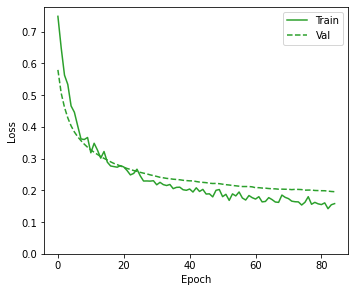

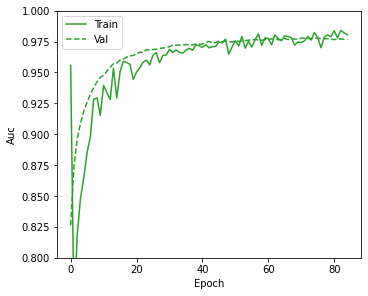

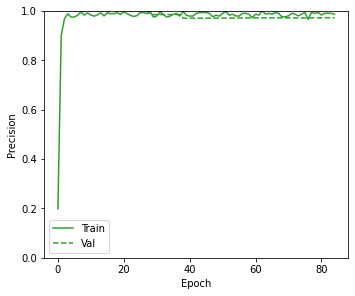

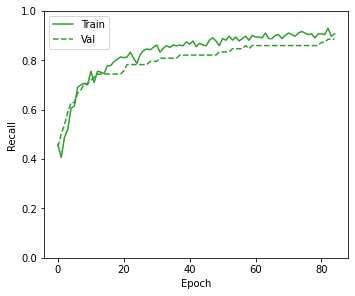

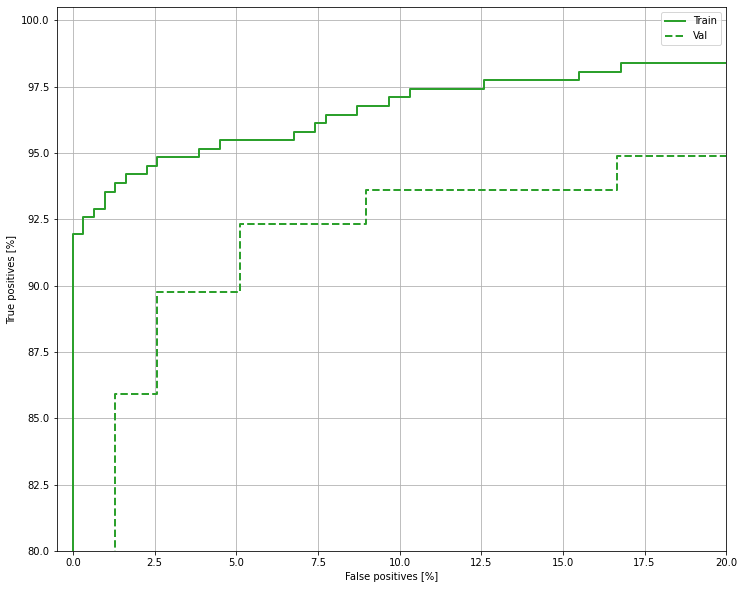

------------------------------------------------------------------------
Training for fold 2 ...


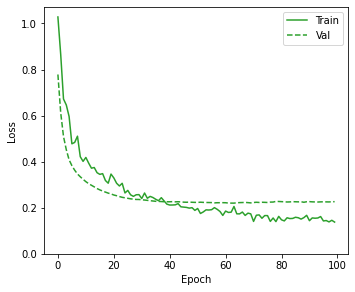

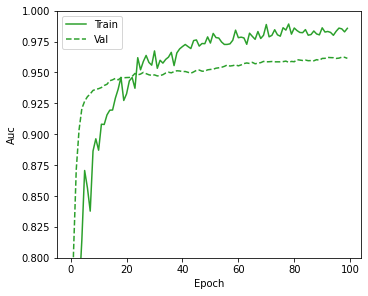

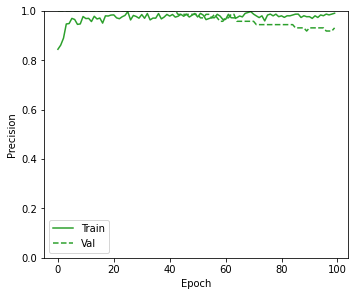

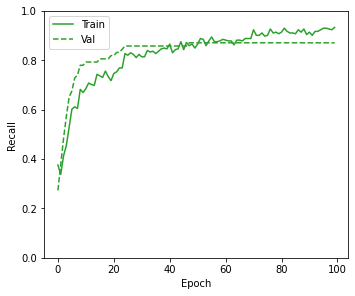

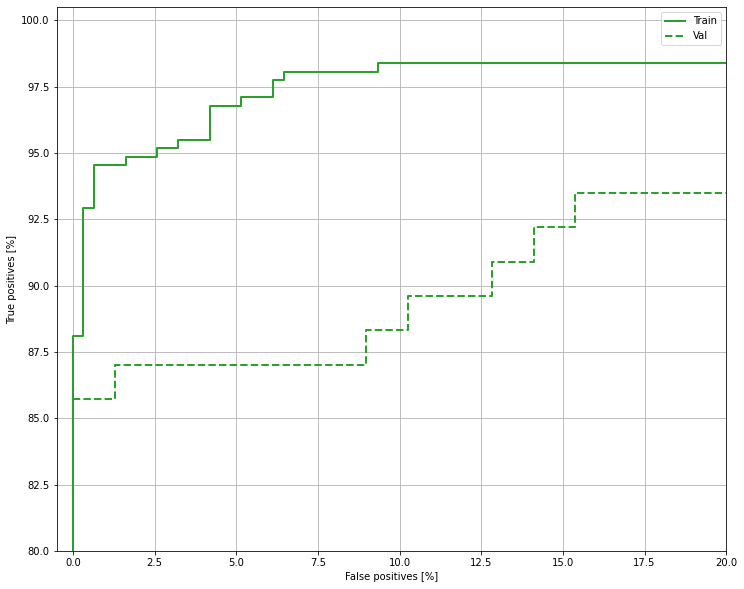

------------------------------------------------------------------------
Training for fold 3 ...


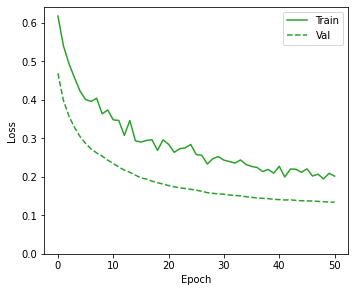

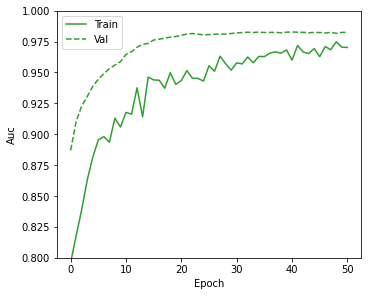

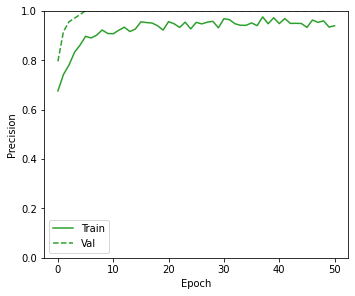

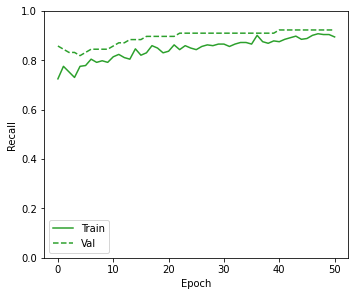

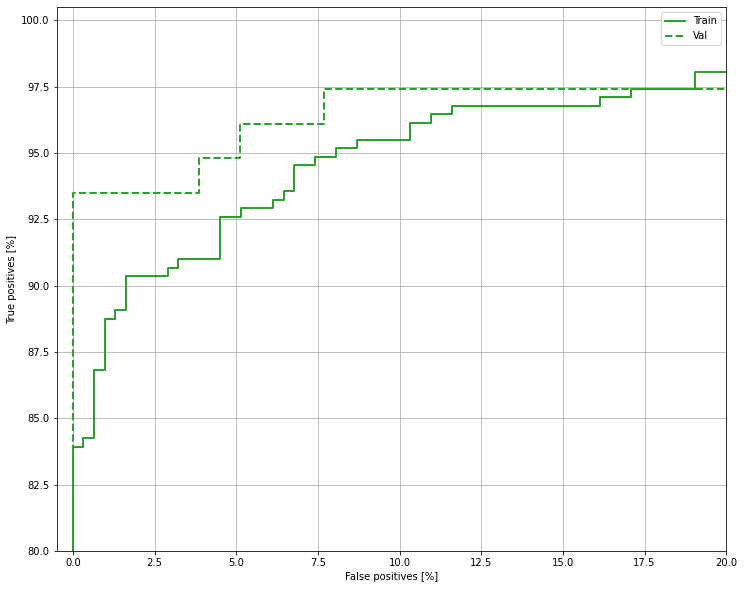

------------------------------------------------------------------------
Training for fold 4 ...


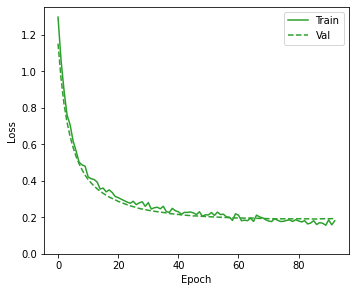

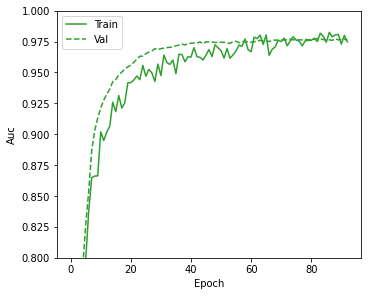

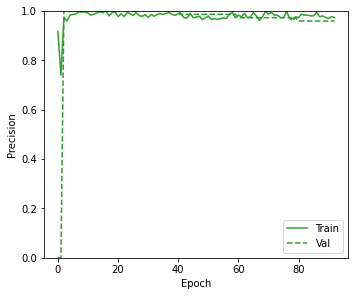

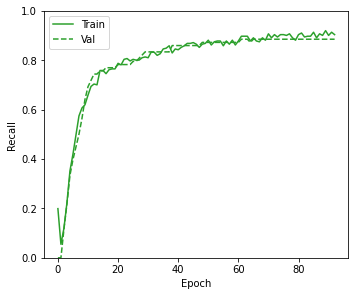

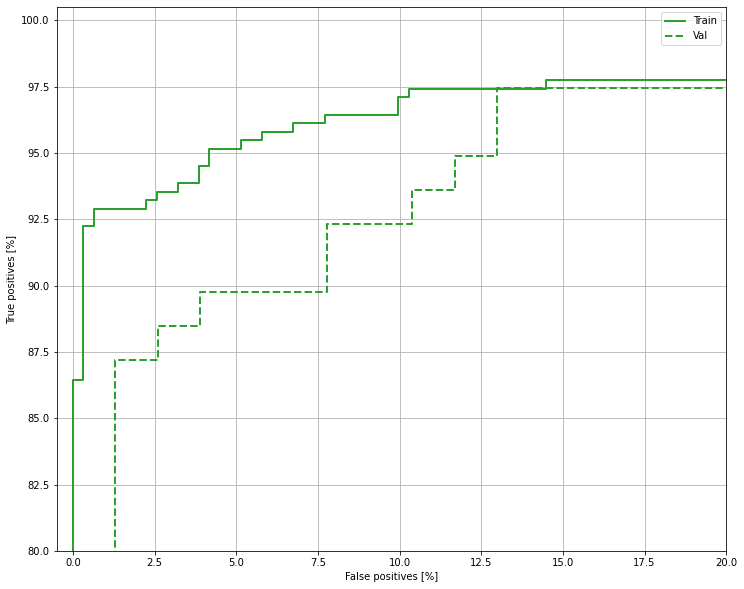

------------------------------------------------------------------------
Training for fold 5 ...


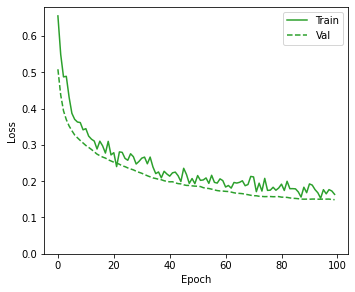

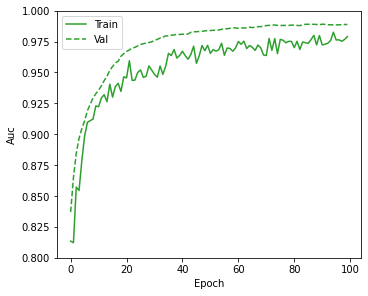

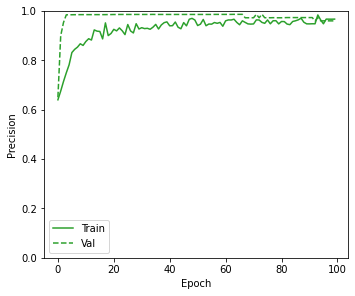

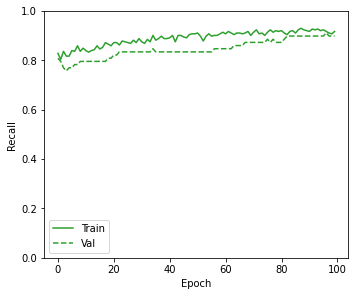

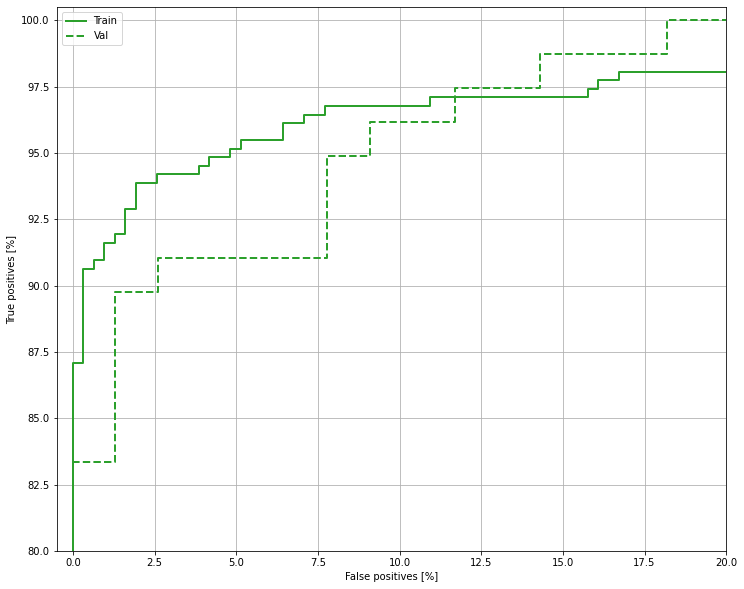

Accuracy:  0.9265591382980347 +/- 0.021385684652547497
Precision:  0.9638756513595581 +/- 0.026752648959177904
Recall:  0.8866466760635376 +/- 0.021974838557010063
AUC:  0.9779293656349182 +/- 0.008835892163238478


In [217]:
VALIDATION_ACCURACY = []
VALIDATION_PRECISION = []
VALIDATION_RECALL = []
VALIDATION_AUC = []

save_dir = '/content/'
fold_var = 1

EPOCHS = 100
BATCH_SIZE = 32

for train_index, val_index in skf.split(np.zeros(n_samples),Y):
  train_data_kfold = train_under_df_features.iloc[train_index]
  val_data_kfold = train_under_df_features.iloc[val_index]

  train_labels_kfold = train_under_df_labels.iloc[train_index]
  val_labels_kfold = train_under_df_labels.iloc[val_index]

  # Convert the DataFrame into np arrays of labels and features.
  train_features_kfold = np.array(train_data_kfold)
  val_features_kfold = np.array(val_data_kfold)
  
  train_labels_kfold = np.array(train_labels_kfold)
  val_labels_kfold = np.array(val_labels_kfold)

  # Build the model.
  model = make_model(input_features=train_under_features)

  # Create Callbacks
  # This saves the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(get_model_name(fold_var), 
              monitor='val_auc', verbose=0, 
              save_best_only=True, mode='max')

  # This is for early stopping
  early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)
  
  #List of callbacks
  callbacks_list = [checkpoint, early_stopping]  

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_var} ...')

  # Fit the Model  
  under_history_kfold = model.fit(
    train_features_kfold,
    train_labels_kfold,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    validation_data=(val_features_kfold, val_labels_kfold),
    verbose=0)

  #PLOT HISTORY
  plot_metrics(under_history_kfold, color_num = 2, stack=1)

  # LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights(get_model_name(fold_var))

  under_results_kfold = model.evaluate(val_features_kfold, val_labels_kfold,
                                  batch_size=BATCH_SIZE, verbose=0)
  
  train_predictions_kfold = model.predict(train_features_kfold, batch_size=BATCH_SIZE)
  val_predictions_kfold = model.predict(val_features_kfold, batch_size=BATCH_SIZE)

  plot_roc_kfold(train_labels_kfold, train_predictions_kfold,
                 val_labels_kfold, val_predictions_kfold, color=colors[2])    

  VALIDATION_ACCURACY.append(under_results_kfold[5])
  VALIDATION_PRECISION.append(under_results_kfold[6])
  VALIDATION_RECALL.append(under_results_kfold[7])
  VALIDATION_AUC.append(under_results_kfold[8])

  tf.keras.backend.clear_session()

  fold_var += 1

print("Accuracy: ", np.mean(VALIDATION_ACCURACY), "+/-", np.std(VALIDATION_ACCURACY))
print("Precision: ", np.mean(VALIDATION_PRECISION), "+/-", np.std(VALIDATION_PRECISION))
print("Recall: ", np.mean(VALIDATION_RECALL), "+/-", np.std(VALIDATION_RECALL))
print("AUC: ", np.mean(VALIDATION_AUC), "+/-", np.std(VALIDATION_AUC))


### Check training history

In [218]:
model_under = make_model(input_features=train_under_features)

# This saves the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model_under.h5", 
            monitor='auc', verbose=0, 
            save_best_only=True, mode='max')

# This is for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
  monitor='auc', 
  verbose=0,
  patience=10,
  mode='max',
  restore_best_weights=True)
  
#List of callbacks
callbacks_list = [checkpoint, early_stopping] 

under_history = model_under.fit(
    train_under_features,
    train_under_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = callbacks_list,
    verbose=1)

Epoch 1/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7252 - tp: 416.0000 - fp: 297.0000 - tn: 168.0000 - fn: 50.0000 - accuracy: 0.6273 - precision: 0.5835 - recall: 0.8927 - auc: 0.7999
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5436 - tp: 342.0000 - fp: 182.0000 - tn: 206.0000 - fn: 46.0000 - accuracy: 0.7062 - precision: 0.6527 - recall: 0.8814 - auc: 0.8462
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5071 - tp: 322.0000 - fp: 131.0000 - tn: 257.0000 - fn: 66.0000 - accuracy: 0.7461 - precision: 0.7108 - recall: 0.8299 - auc: 0.8495
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4194 - tp: 335.0000 - fp: 88.0000 - tn: 300.0000 - fn: 53.0000 - accuracy: 0.8183 - precision: 0.7920 - recall: 0.8634 - auc: 0.8967
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3985 - tp: 321.0000 - fp: 57.0000 - tn: 331.0000 - fn: 67.0000 - accuracy: 0.8402 - precis

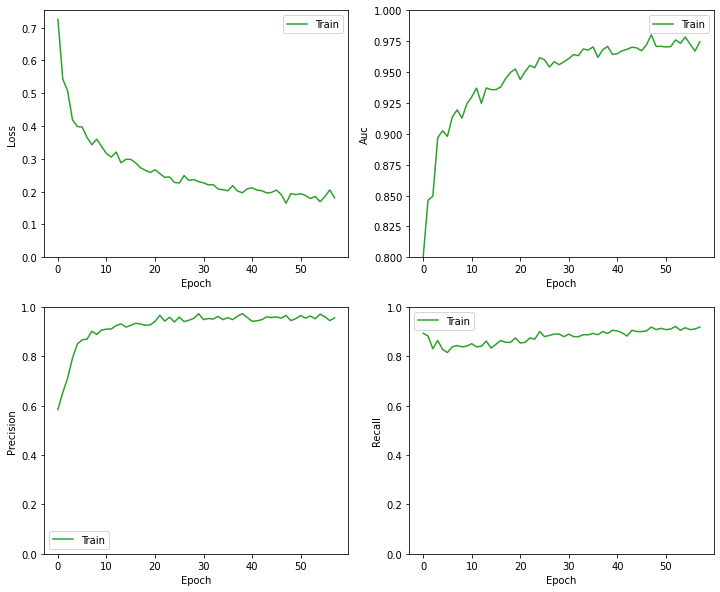

In [219]:
plot_metrics(under_history, color_num = 2, stack = 0, validation = 0)

### Evaluate metrics and confusion matrix:

Train confusion matrix...

loss :  0.14232221245765686
tp :  353.0
fp :  3.0
tn :  385.0
fn :  35.0
accuracy :  0.9510309100151062
precision :  0.9915730357170105
recall :  0.9097937941551208
auc :  0.984227180480957

Legitimate Transactions Detected (True Negatives):  385
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  35
Fraudulent Transactions Detected (True Positives):  353
Total Fraudulent Transactions:  388


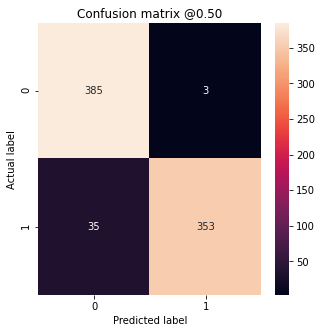

In [220]:
train_predictions_under = model_under.predict(train_under_features, batch_size=BATCH_SIZE)

under_results_train = model_under.evaluate(train_under_features, train_under_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_under.metrics_names, under_results_train):
  print(name, ': ', value)
print()

plot_cm(train_under_labels, train_predictions_under)

...and test confusion matrix.

In [221]:
# Load best model to evaluate performance
model_under.load_weights("best_model_under.h5")

train_predictions_under = model_under.predict(train_under_features, batch_size=BATCH_SIZE)
test_predictions_under = model_under.predict(test_under_features, batch_size=BATCH_SIZE)

loss :  0.1315067857503891
tp :  98.0
fp :  2.0
tn :  102.0
fn :  6.0
accuracy :  0.9615384340286255
precision :  0.9800000190734863
recall :  0.942307710647583
auc :  0.984143853187561

Legitimate Transactions Detected (True Negatives):  102
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  6
Fraudulent Transactions Detected (True Positives):  98
Total Fraudulent Transactions:  104


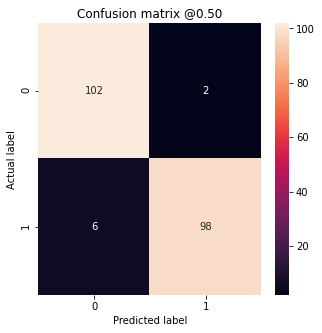

In [222]:
under_results = model_under.evaluate(test_under_features, test_under_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_under.metrics_names, under_results):
  print(name, ': ', value)
print()

plot_cm(test_under_labels, test_predictions_under)

In [223]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  #plt.xlim([-1,100.5]) #Total
  #plt.ylim([-1,100.5]) #Total
  plt.xlim([-0.5,20]) #Better visualization
  plt.ylim([80,100.5]) #Better visualization
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

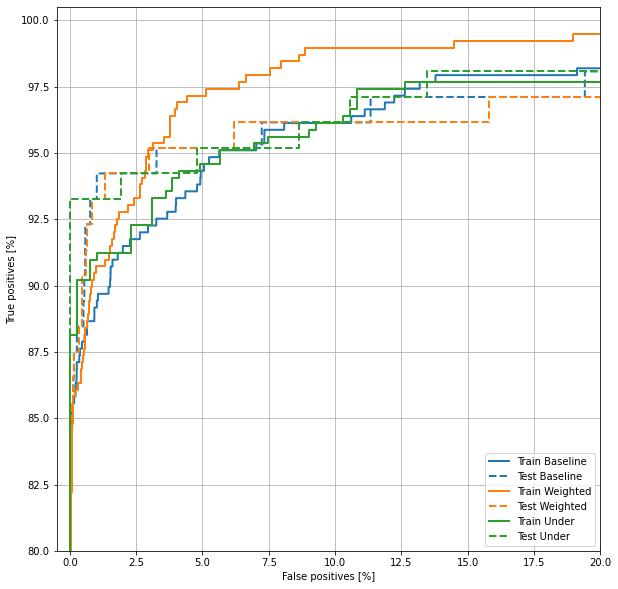

In [224]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Under", train_under_labels, train_predictions_under, color=colors[2])
plot_roc("Test Under", test_under_labels, test_predictions_under, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

Notice that these results are for the undersampled test dataset, which does not carry the imbalance of the original problem. Let's create a test dataset that has the same proportion of fraud/non-fraud samples as the original dataset. 

loss :  2.6618335247039795
tp :  104.0
fp :  50644.0
tn :  6214.0
fn :  0.0
accuracy :  0.11091604828834534
precision :  0.0020493417978286743
recall :  1.0
auc :  0.9453534483909607

Legitimate Transactions Detected (True Negatives):  6214
Legitimate Transactions Incorrectly Detected (False Positives):  50644
Fraudulent Transactions Missed (False Negatives):  0
Fraudulent Transactions Detected (True Positives):  104
Total Fraudulent Transactions:  104


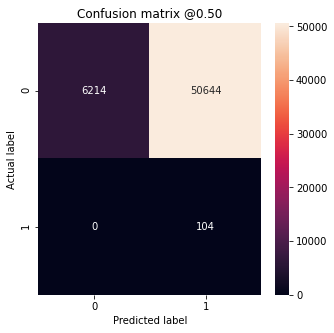

In [225]:
BATCH_SIZE = 2048

test_predictions_under_2 = model_under.predict(test_bal_features, batch_size=BATCH_SIZE)

under_results_2 = model_under.evaluate(test_bal_features, test_bal_labels,
                                           batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model_under.metrics_names, under_results_2):
  print(name, ': ', value)
print()

plot_cm(test_bal_labels, test_predictions_under_2)

When the model is applied to an unbalanced dataset, it is capable of identifying all the positive samples, but at the cost of wrongly classifying most of the non-fraud samples as frauds. Therefore, one can conclude that this is not a good approach to the problem. 

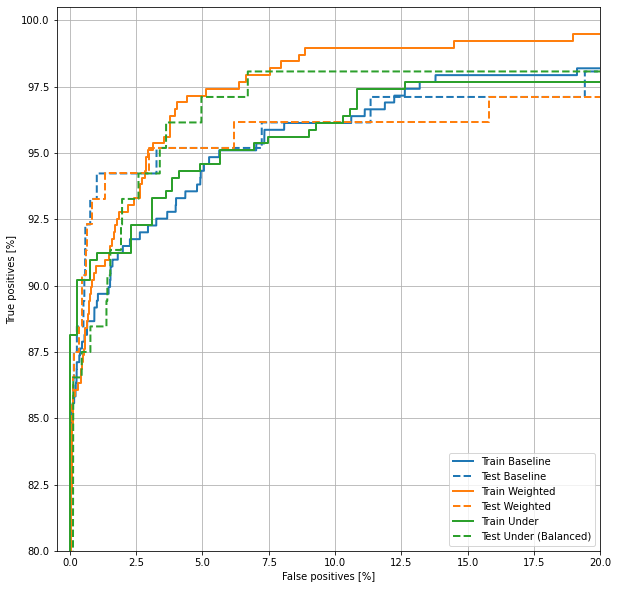

In [226]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Under", train_under_labels, train_predictions_under, color=colors[2])
plot_roc("Test Under (Balanced)", test_bal_labels, test_predictions_under_2, color=colors[2], linestyle='--')

plt.legend(loc='lower right')

##Conclusion

From all this study, we get the following conclusions:

*   The baseline model has a good precision, but it fails in classyfing most of the positive samples, which is a bad thing given the context of the problem: letting go fraudulent transactions is worst than incorrectly classifying legitimate transactions as frauds. This approach has high precision, but average recall. 
*   The weighted model classifies many legitimate transactions as fraudulent, but it is capable of catching most of the true positives. So here we have high recall, with low precision.
* The undersample approach has high precision and recall when applied to a balanced dataset, but classifies a very large number of legitimate transactions as fraudulent when applied to the imbalanced dataset. So we have very high recall and very low precision. It is good to catch all the frauds, but classifying so many legitimate transactions as fraudulent would annoy the customers. 

Final veredict: The weighted model is probably the best approach to this problem.

##Other approaches to the problem

One of the most upvoted notebooks in Kaggle for the Credit Card Fraud Detection dataset uses logistic regression with random undersampling  to deal with the problem. These are the confusion matrices its model gets for the balanced (left) and imbalanced (right) datasets.


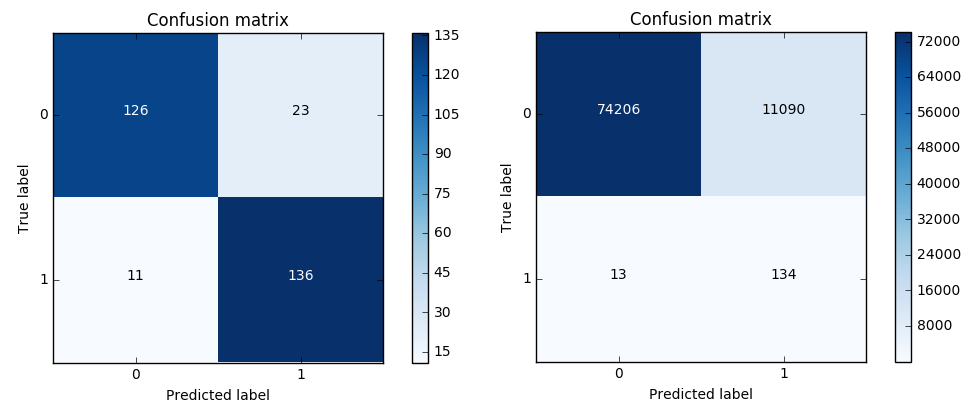





Notice that it faces the same problem of our model when dealing with the imbalanced dataset, it classifies many negative samples as frauds (false positives). In fact, it is worse as it also has a high number of false negatives 

One can see more on the solution in the link https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now